In [22]:
import pandas as pd
import pymongo
from pymongo import MongoClient
from datetime import datetime

# Useful functions

In [5]:
myclient = MongoClient("mongodb://localhost:27017/")

In [6]:
def insert_to_mgdb_from_quandl(ticker="", strating_date="1900-01-01", ending_date="",client_name="forex_data", collection_name="closing_prices"):
    if not ending_date:
        today = datetime.today()
        ending_date = today.strftime("%Y-%m-%d")
    df = quandl.get(ticker, start_date=strating_date, end_date=ending(date))
    
    df.reset_index(inplace=True)
    data_dict = df.to_dict("records")
    
    mydb = myclient[client_name]
    mycol = mydb[collection_name]
    
    mycol.insert_one({"index":ticker,"data":data_dict})
    return(data)

In [7]:
def insert_to_mgdb_from_excel(csv_file_name="", client_name="forex_data", collection_name="closing_prices",set_index_to_datetime=True):
    if not csv_file_name:
        print("Specify file name")
        return()
    df = pd.read_csv(csv_file_name, index_col=0)
    if set_index_to_datetime:
        df.index = pd.to_datetime(df.index)
    df.columns = [csv_file_name[:-4]]
    
    df.reset_index(inplace=True)
    data_dict = df.to_dict("records")
    
    mydb = myclient[client_name]
    mycol = mydb[collection_name]
    
    mycol.insert_one({"index":csv_file_name[:-4],"data":data_dict})
    return(df.set_index('Date'))

In [8]:
def read_mgdb_data(index_name="" ,client_name="forex_data", collection_name="closing_prices", set_index_on_date=True):
    if not index_name:
        print("Specify index name")
        return()
    
    mydb = myclient[client_name]
    mycol = mydb[collection_name]
    
    data_from_db = mycol.find_one({"index":index_name})
    df = pd.DataFrame(data_from_db['data'])
    if set_index_on_date:
        df = df.set_index("Date")
    return(df)

In [9]:
def get_day_before(df, date):
    loc = df.getloc(date)
    prev_date = df.iloc[loc-1]
    return(prev_date)

In [151]:
USDMAD = read_mgdb_data("USDMAD")
GBPMAD = read_mgdb_data("GBPMAD")
EURMAD = read_mgdb_data("EURMAD")
AEDMAD = read_mgdb_data("AEDMAD")
SEKMAD = read_mgdb_data("SEKMAD")
MGAMAD = read_mgdb_data("MGAMAD")

***************************************************************************************************
----------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------
----------------------------
------------------
-----------

# Chargement des données

In [152]:
n = 1300
USDMAD=USDMAD.iloc[-n:]
MGAMAD=MGAMAD.iloc[-n:]
EURMAD=EURMAD.iloc[-n:]
tickers = ["USDMAD", "EURMAD","MGAMAD"]
dfs = [USDMAD, EURMAD, MGAMAD]

In [153]:
# Creation d'un dataframe qui rassemble tout les taux de cloture
PX_LAST = USDMAD
for ticker in dfs[1:]:
    PX_LAST = pd.merge(PX_LAST, ticker, on='Date',how='outer')
PX_LAST = PX_LAST.sort_index()

In [154]:
# Calcule de la performance des données
PX_LAST = PX_LAST.ffill().bfill()
returns = PX_LAST/PX_LAST.shift(1) - 1

# Calcul de l'excess return des taux de change

En d'autres termes on va rebaser nos taux à un niveau de reférence de 1000

In [155]:
CERL = pd.DataFrame(index=PX_LAST.index, columns=PX_LAST.columns )
base_date = datetime(2019,3,1)
base_level = 1000
for ticker in tickers:
    CERL.loc[base_date, ticker] = base_level

In [156]:
t_1 = base_date
for t in CERL.index[1:]:
    CERL.loc[t] = CERL.loc[t_1]*(1+returns.loc[t])
    t_1 = t

# Components Excess Return Level

<AxesSubplot:xlabel='Date'>

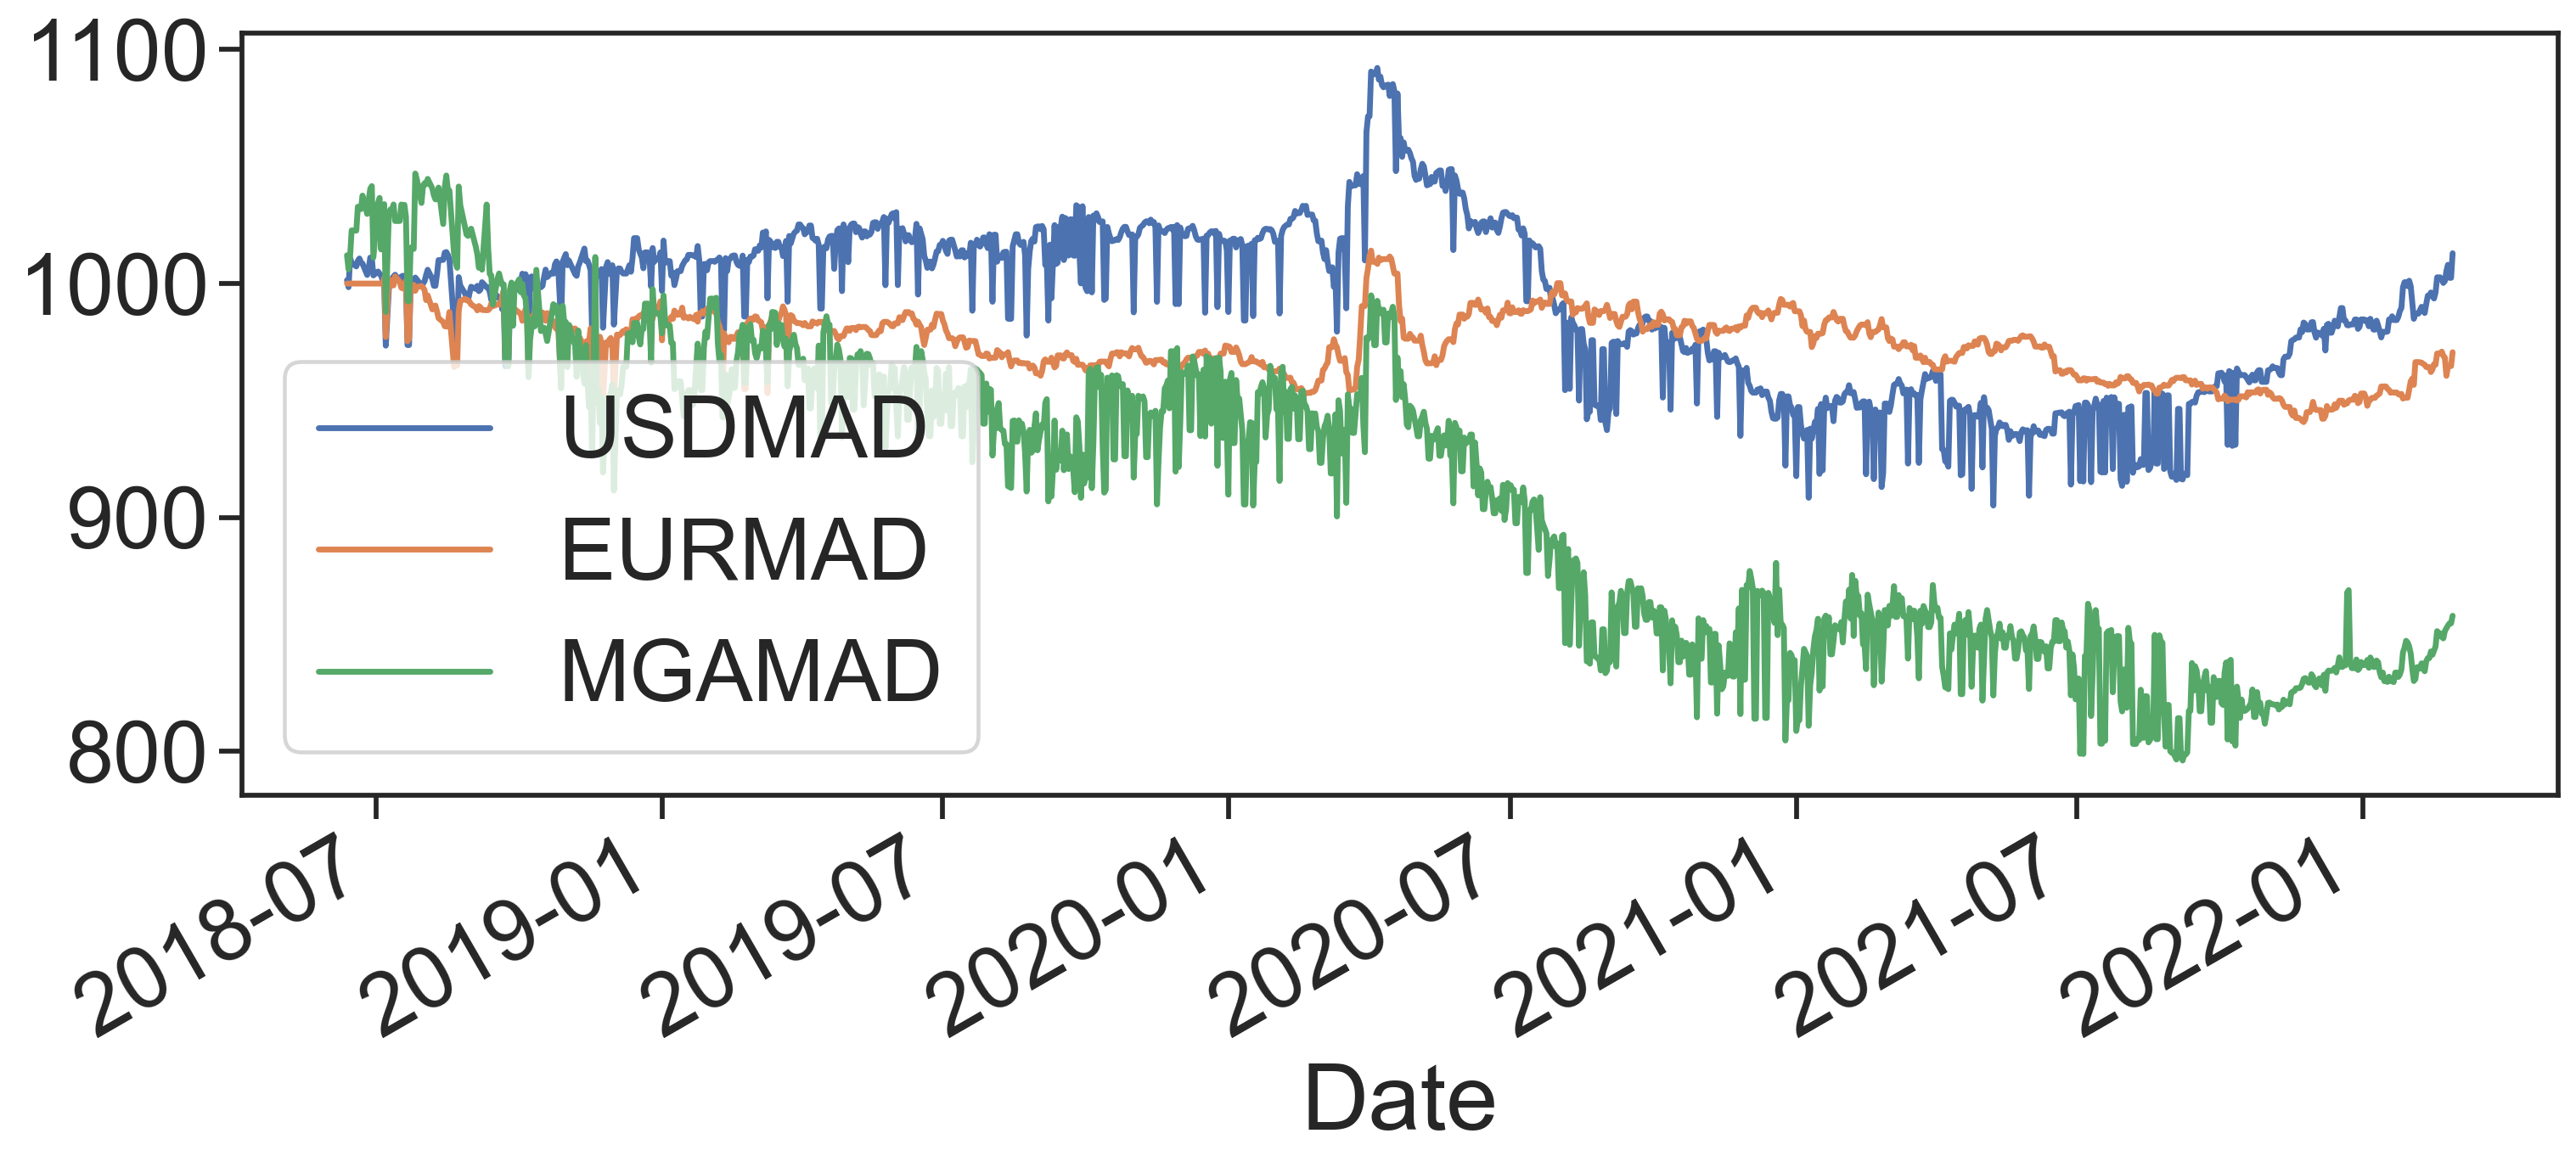

In [157]:
CERL.plot(figsize=(16,6))

In [158]:
from scipy import stats

# Tests statistiques

In [163]:
print("La p-value du test JB pour l'EUR est : " +str(stats.jarque_bera(EURMAD).pvalue))
print("La p-value du test JB pour l'USD est : " +str(stats.jarque_bera(USDMAD).pvalue))
print("La p-value du test JB pour l'MGA est : " +str(stats.jarque_bera(MGAMAD).pvalue))

La p-value du test JB pour l'EUR est : 0.0012121431460069276
La p-value du test JB pour l'USD est : 5.518560500339387e-05
La p-value du test JB pour l'MGA est : 0.0


In [164]:
print("La p-value du test SW pour l'EUR est : " +str(stats.shapiro(EURMAD).pvalue))
print("La p-value du test SW pour l'USD est : " +str(stats.shapiro(USDMAD).pvalue))
print("La p-value du test SW pour l'MGA est : " +str(stats.shapiro(MGAMAD).pvalue))


La p-value du test SW pour l'EUR est : 5.935749808338997e-11
La p-value du test SW pour l'USD est : 4.0470076166952896e-17
La p-value du test SW pour l'MGA est : 9.780950679759627e-24


# Skewness Coefficcient

In [165]:
def moment_ordre_n(df, n):
    mean = df.mean()
    df = df - mean
    df = df.pow(n)
    moment = df.mean()
    return(moment)

In [166]:
def skewness_coef(df):
    moment_ordre_3 = moment_ordre_n(df, 3)
    std = df.std()
    skewness = moment_ordre_3/(std.pow(3))
    return(skewness)

In [167]:
skewness_coeficient = skewness_coef(CERL)

In [168]:
skewness_coeficient

USDMAD   -0.171933
EURMAD   -0.082505
MGAMAD    0.097163
dtype: float64

L'interprétation de ce coeFicient, qui permet de mesurer l'asymétrie d'une distribution, est la suivante :
- $\beta_1$ = 0 : distribution symétrique,
- $\beta_1$ > 0 : distribution oblique à gauche,
- $\beta_1$ < 0 : distribution oblique à droi

# Coeffcient de Kurtos

In [169]:
def kurtos_coef(df):
    moment_ordre_4 = moment_ordre_n(df, 4)
    std = df.std()
    kurtos = moment_ordre_4/std.pow(4)
    return(kurtos)

In [170]:
kurtos_coefficient = kurtos_coef(CERL)

In [171]:
kurtos_coefficient

USDMAD    2.499690
EURMAD    2.508493
MGAMAD    1.760779
dtype: float64

L'interprétation de ce coefficient, qui permet de mesurer la concentration centrale d'une distribution, est la suivante :
- $\beta_2$ = 3 : distribution mésocurtique (i.e. aussi concentrée que sous hypothèse de normalité),
- $\beta_2$ > 3 : distribution leptocurtique (i.e. moins concentrée que sous hypothèse de normalité),
- $\beta_2$ < 3 : distribution platicurtique (i.e. plus concentrée que sous hypothèse de normalité)

# Analyse des Log rendments

In [172]:
import numpy as np

In [173]:
log_returns = np.log(returns+1)

In [174]:
usd = log_returns['USDMAD'].iloc[-365:]
print(np.sqrt(np.average(365*np.square(usd))))
print(usd.std()*np.sqrt(365))


0.23936929782989935
0.23967328195871532


# Calcul du quantile à 95%

In [175]:
quantile95 = np.abs(log_returns).quantile(0.95)
quantile95

USDMAD    0.032070
EURMAD    0.004446
MGAMAD    0.036485
Name: 0.95, dtype: float64

In [176]:
import matplotlib.pyplot as plt

In [177]:
import seaborn as sns

In [178]:
from datetime import date


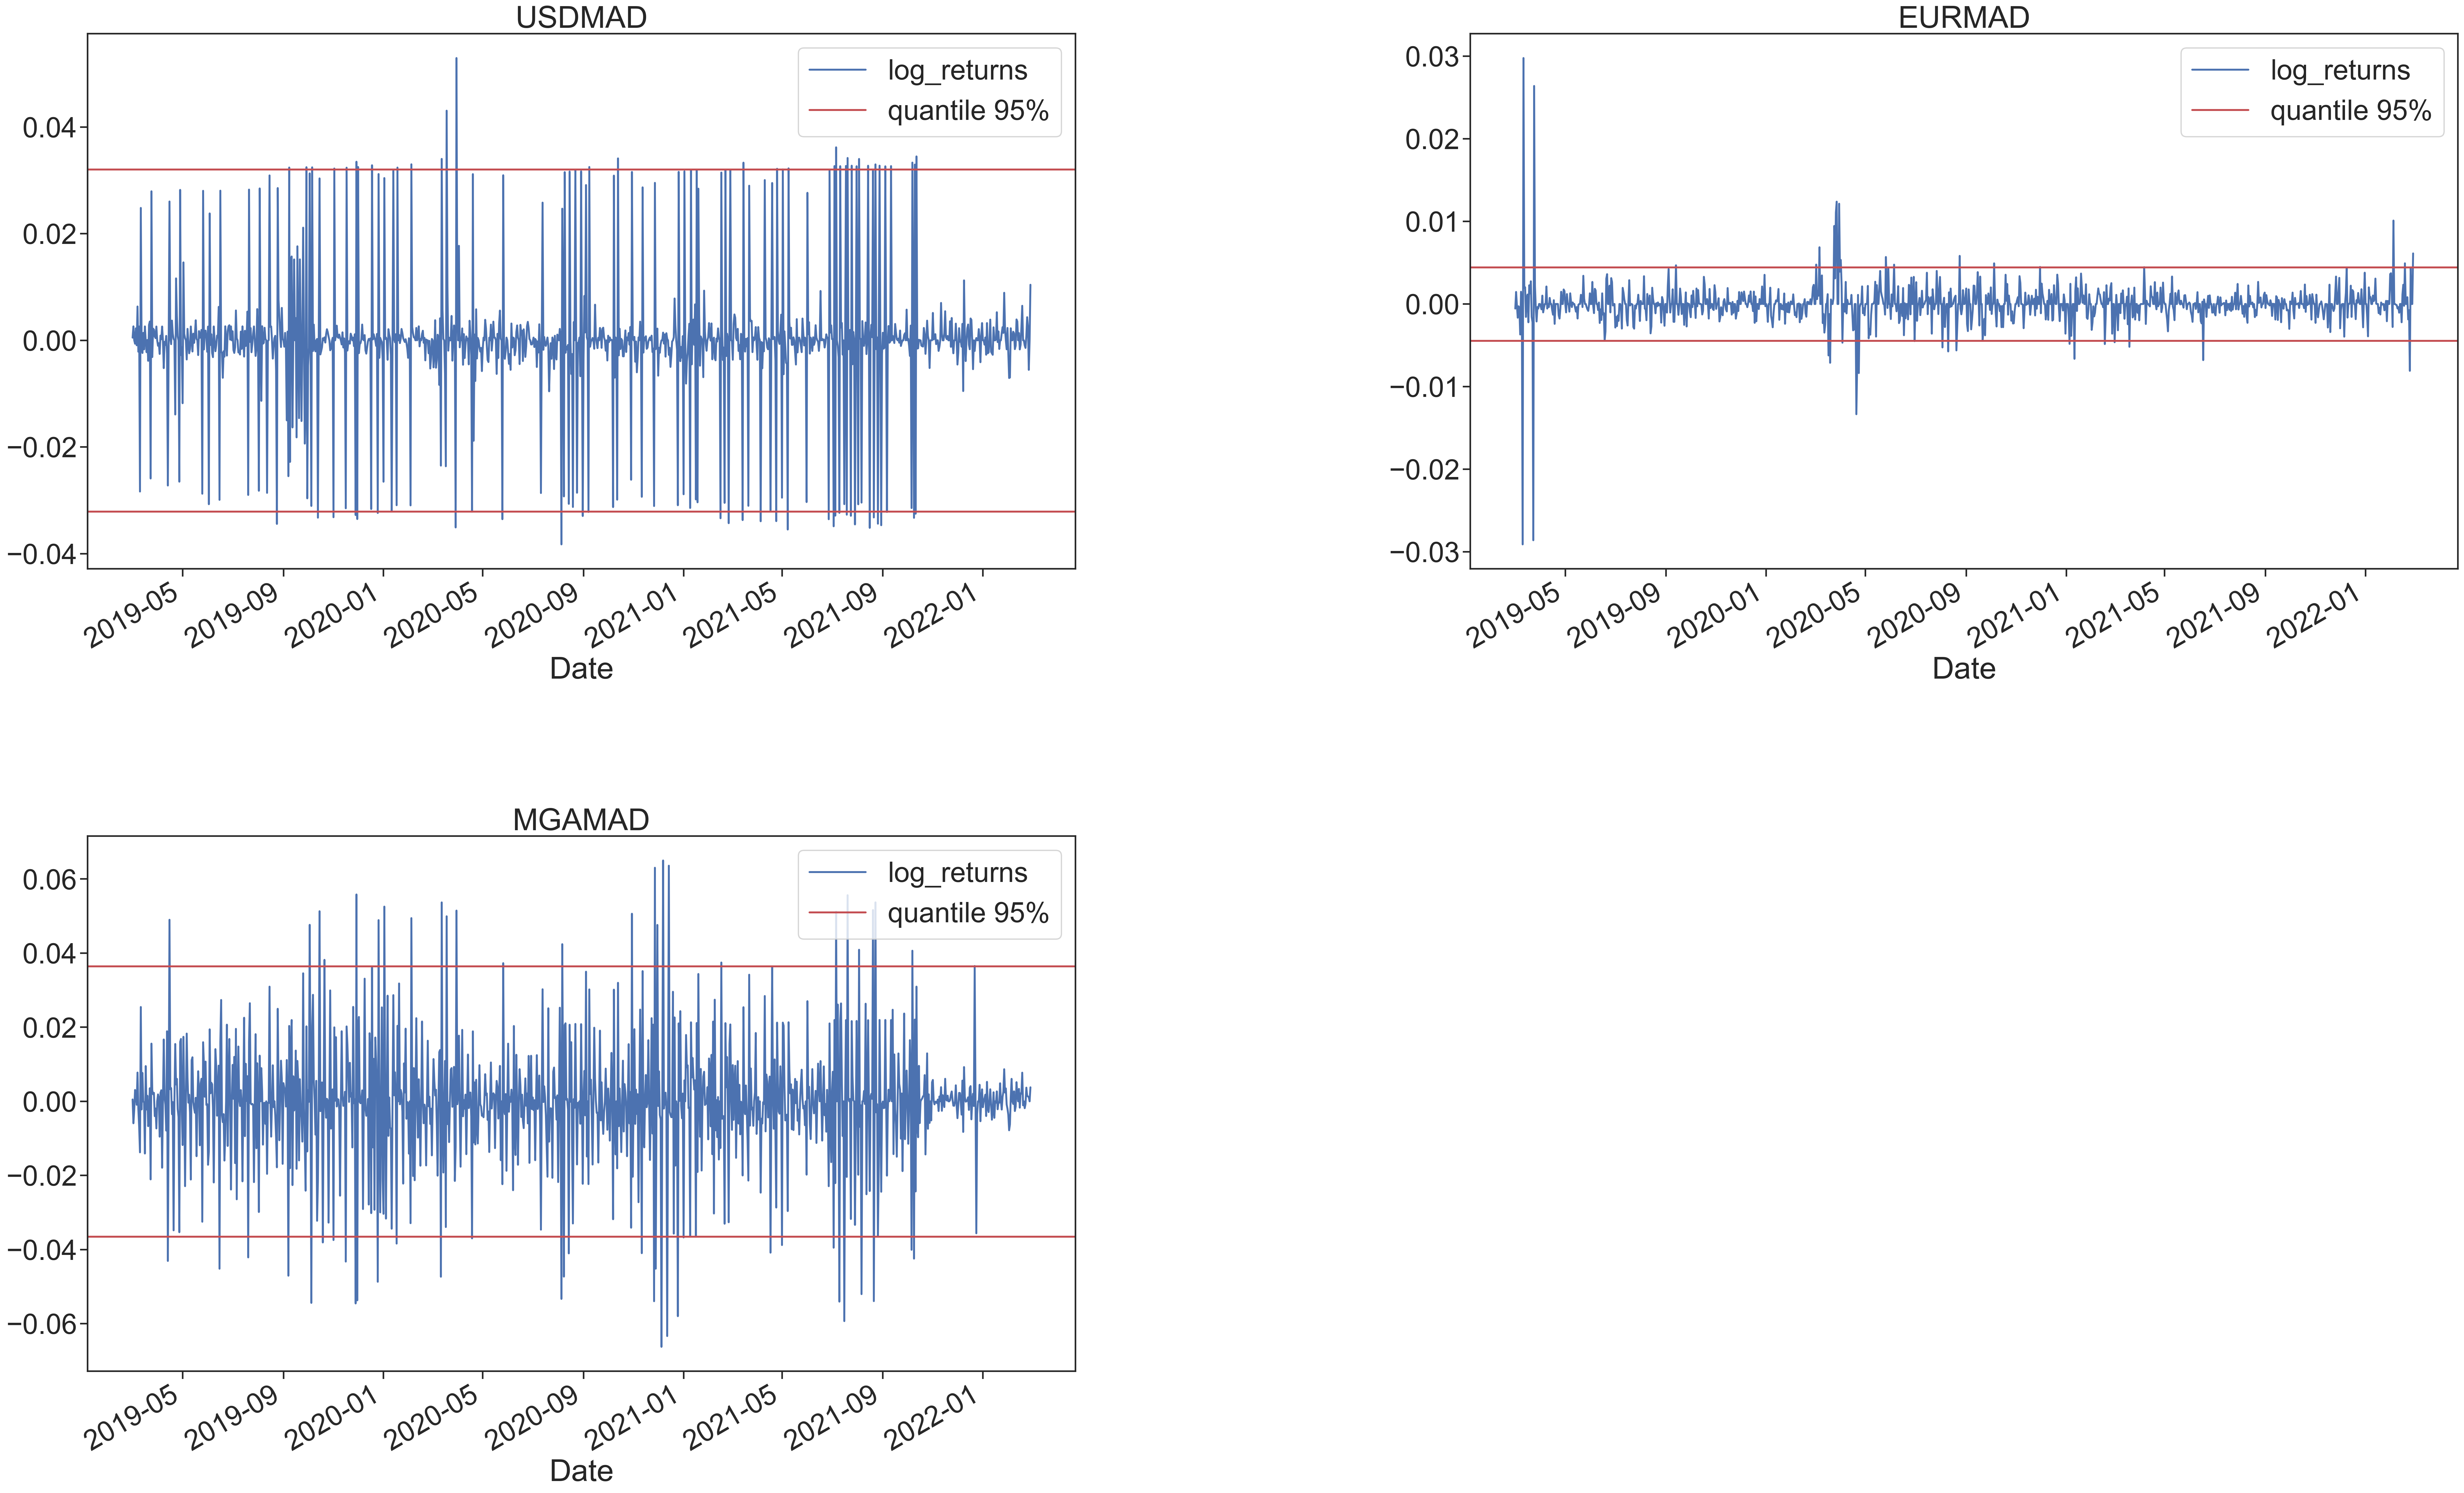

In [179]:
t0 = "2019-03-01"
i = 1
sns.set(style="ticks", context="talk",font_scale = 2)
plt.figure(figsize=(50, 90))
plt.subplots_adjust(wspace=0.4,hspace=0.5)
for ticker in tickers:
    plt.subplot(5,2,i)
    log_returns.loc[t0:, ticker].plot(label="log_returns")
    plt.axhline(quantile95[ticker], color='r', label="quantile 95%", linestyle='-')
    plt.axhline(-quantile95[ticker], color='r', linestyle='-')
    plt.title(ticker)
    l = plt.legend(loc ='upper right')
    i = i +1

# Commentaires

- En analysant la courbe du EUR/MAD, on remarque que depuis le mois d'avril 2008, le taux est beaucoup moins volatile, en effet, il passe d'une volatilité de 2.5% à moins de 1%. De meme pour le GBP.
- Pour l'USD et l'SEK on obsèrve aussi qu'il y'a eu raissement, au debut de 2022 une baisse forte baisse en volatilité, qui passe de 4% à 2%. 

# Qantile-Quantile plot

In [142]:
import statsmodels.api as sm

Un graphique quantile-quantile (QQ-plot) permet d'étudier l'adéquation de la distribution d'une variable à une loi théorique.
Ici, l'axe des abscisses porte les quantiles de la loi théorique, tandis que l'axe des ordonnées porte
ceux de la distribution empirique. Si le nuage de points s'aligne sur la première bissectrice, alors la
loi théorique semble acceptable pour la variable considérée.

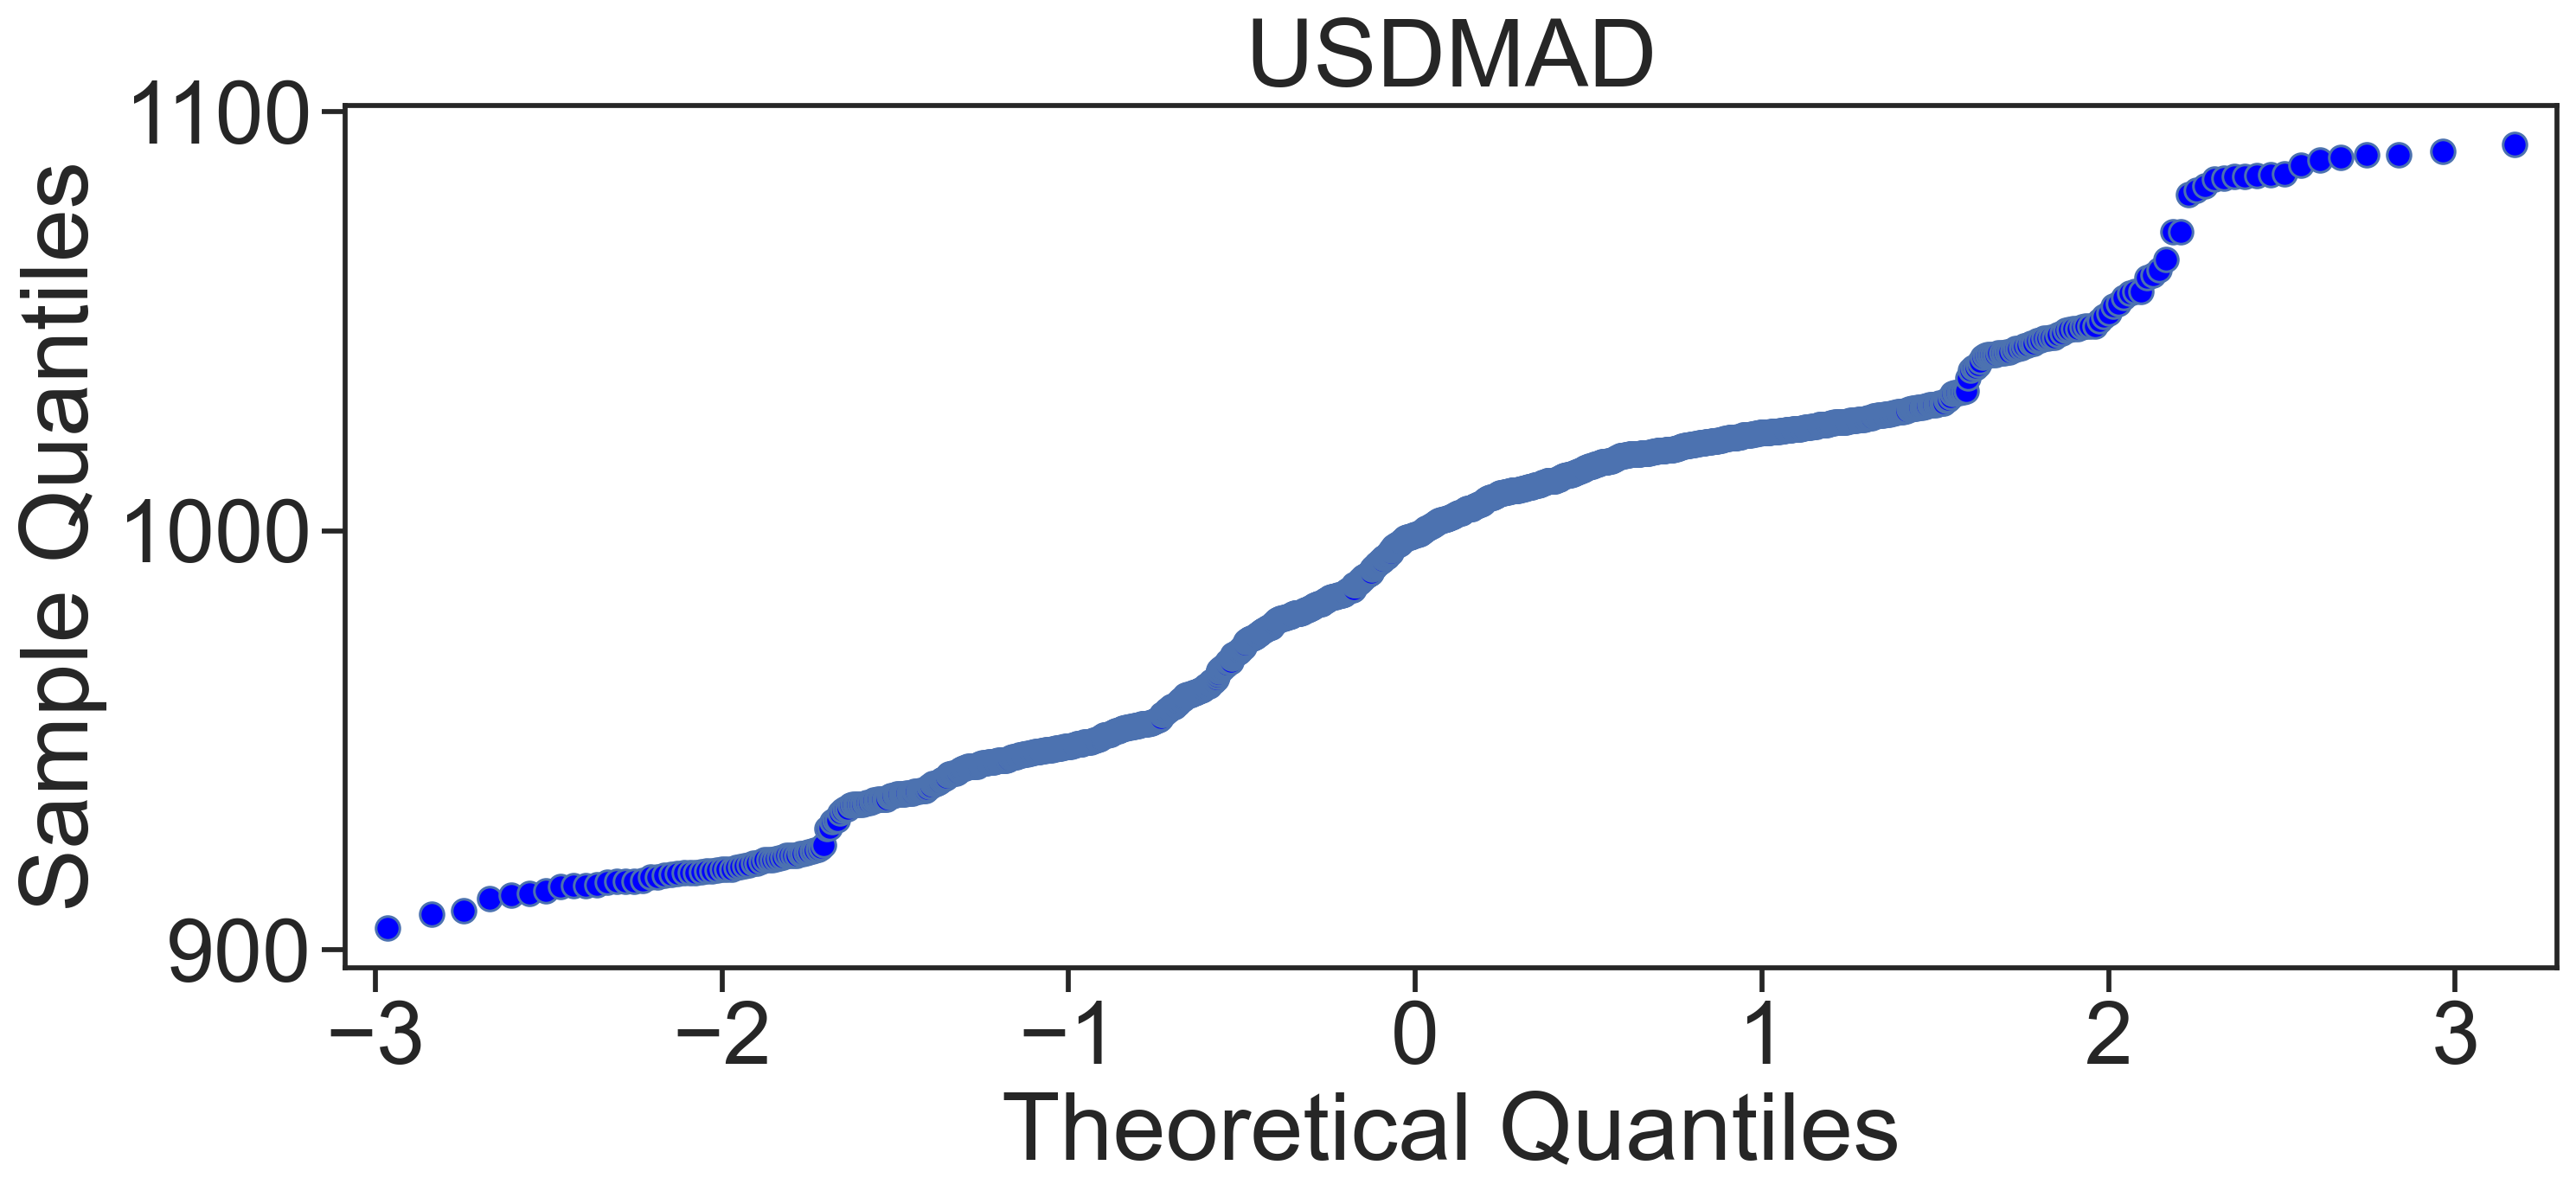

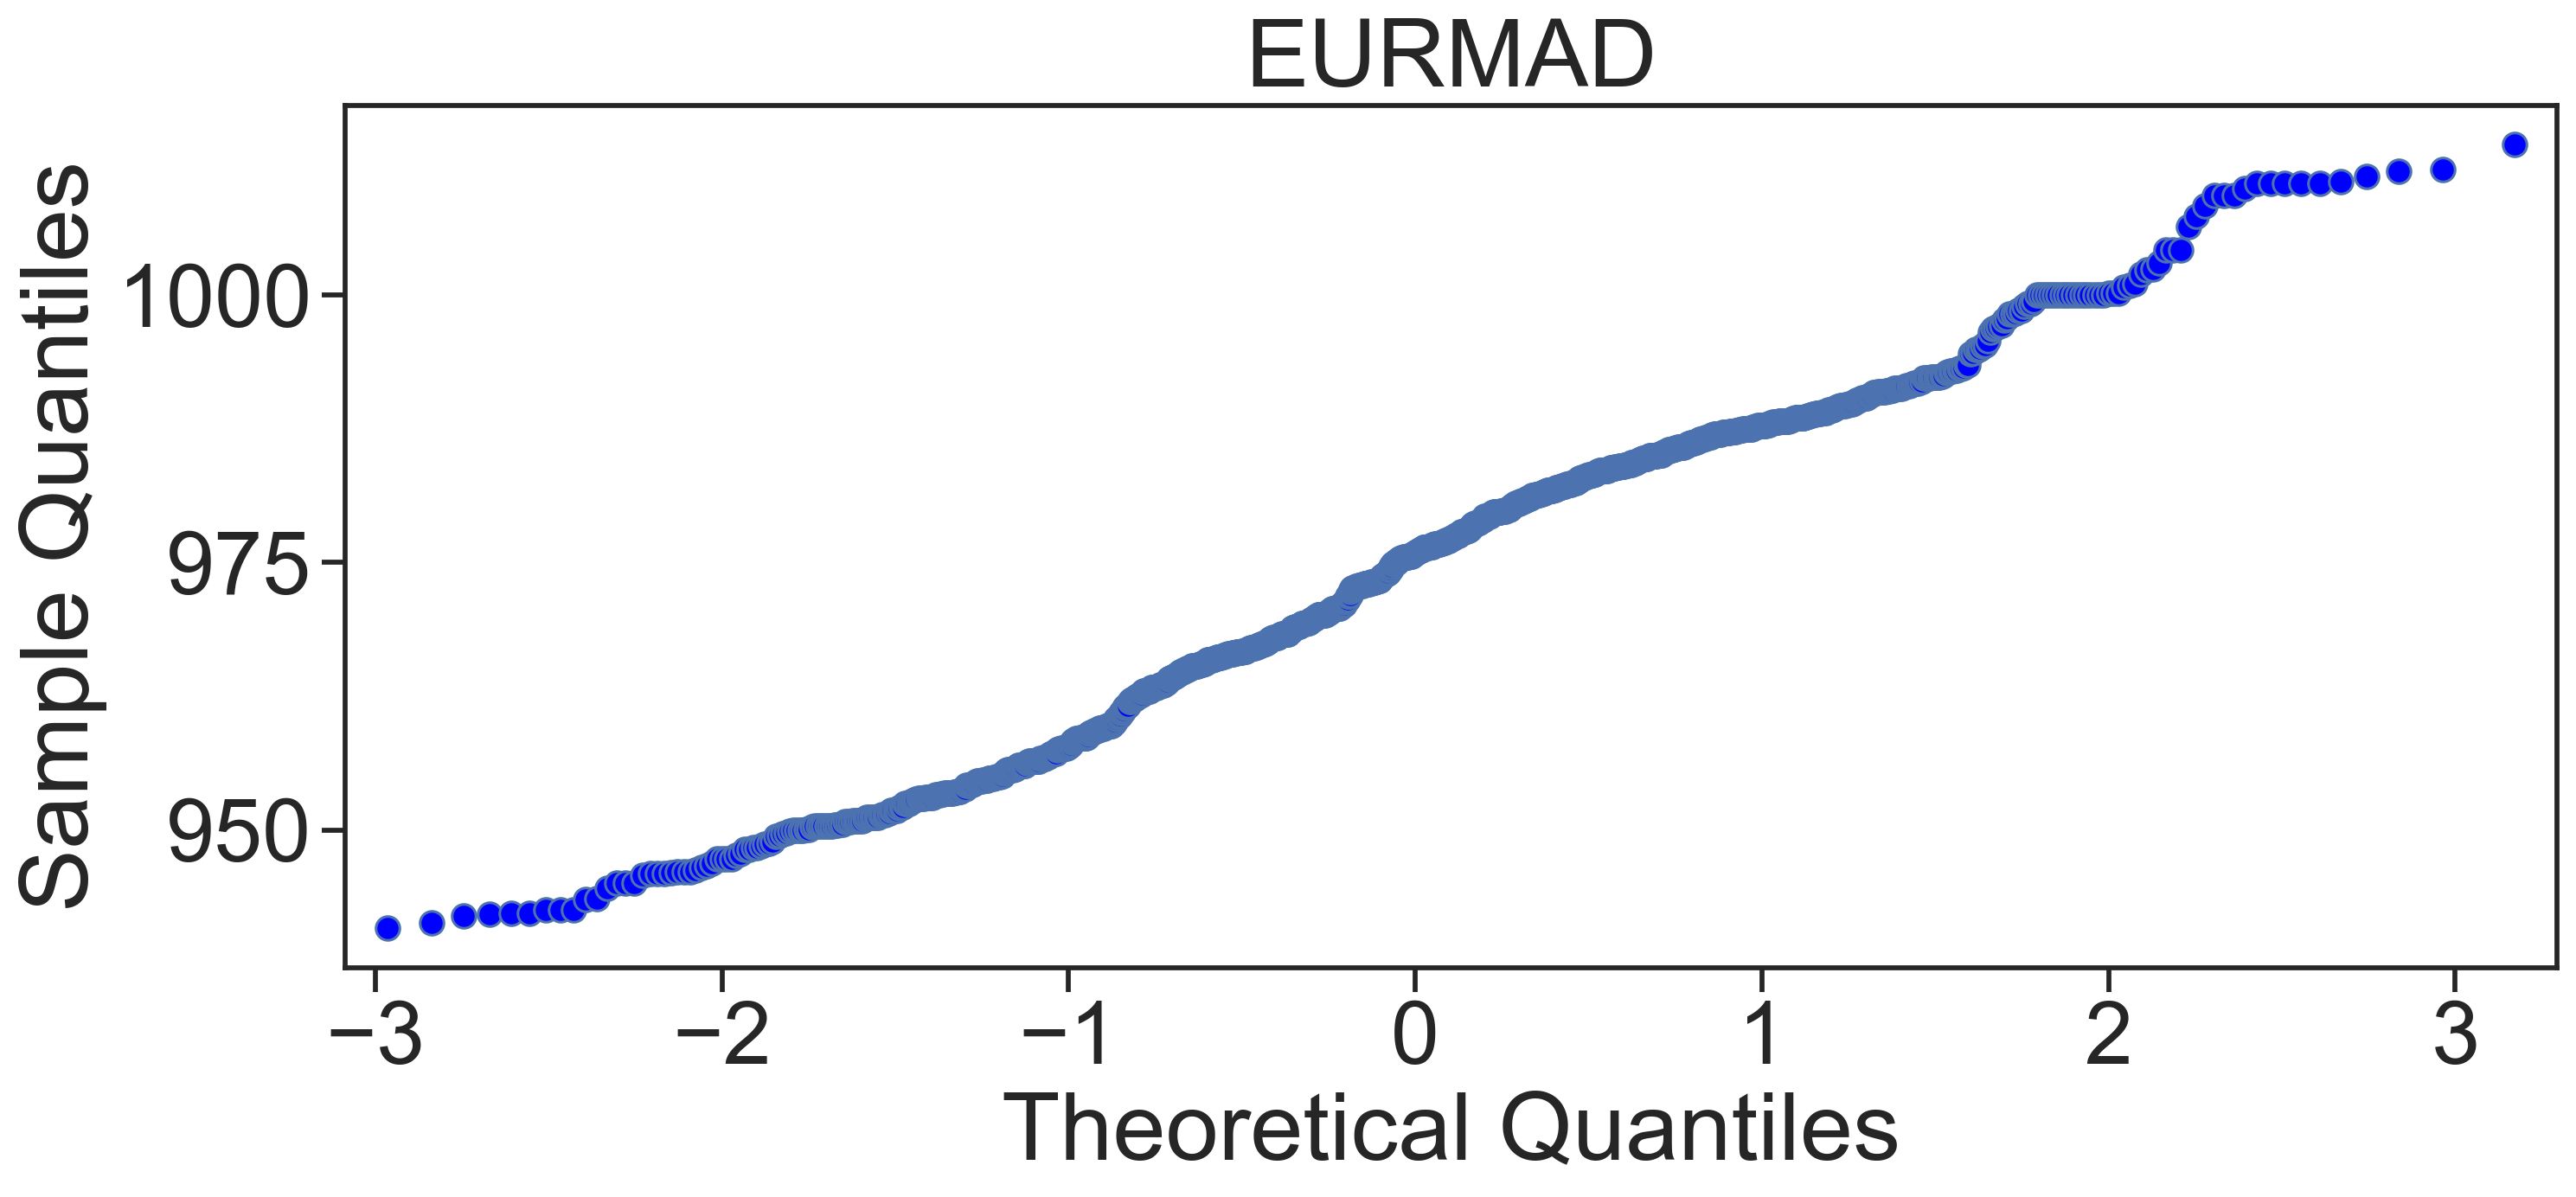

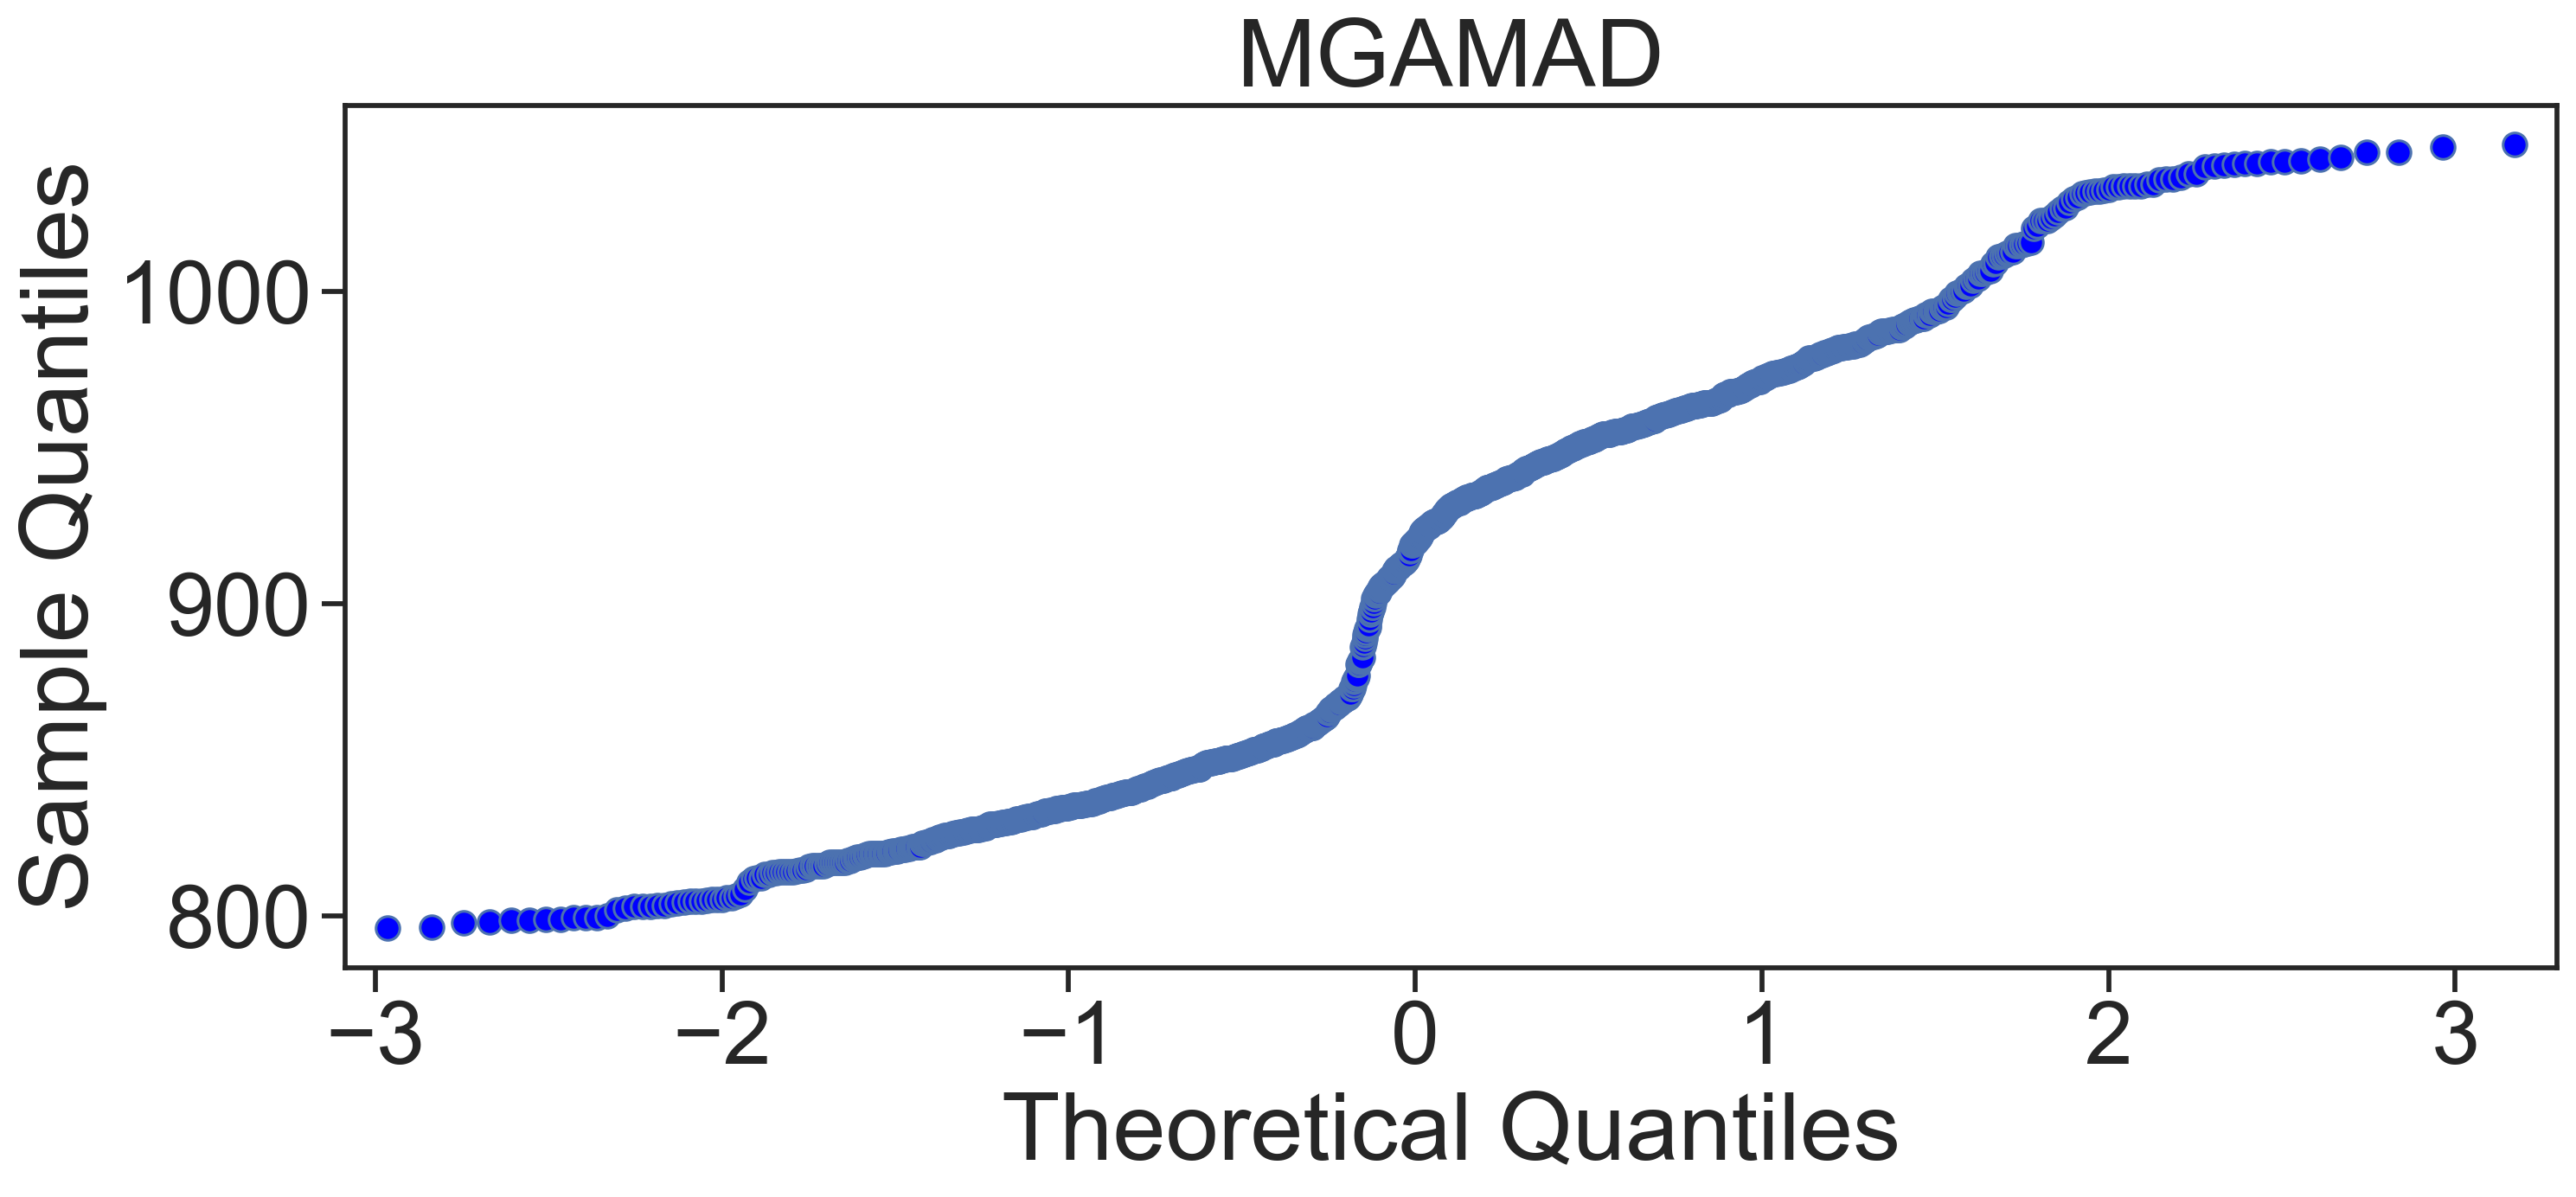

In [143]:
for ticker in tickers:
    sm.qqplot(CERL[ticker], line = "r")
    plt.title(ticker)
    plt.show()

L'analyse statistique des taux de change nous a permis de remarquer que la distribution des logrendements 
ne suivait pas une loi normale. 
cela est dù generalement à deux facteurs:
- Les scenarios extèmes arrivent plus souvent que ce que prédit la loi normale.
- la distribution des taux n'est pas tout a fait symetrique, on remarque que les distributions ont des queues grasses.
![fat_tail]("fat_tail.jpeg")

# Enlèvement des valeures extrèmes

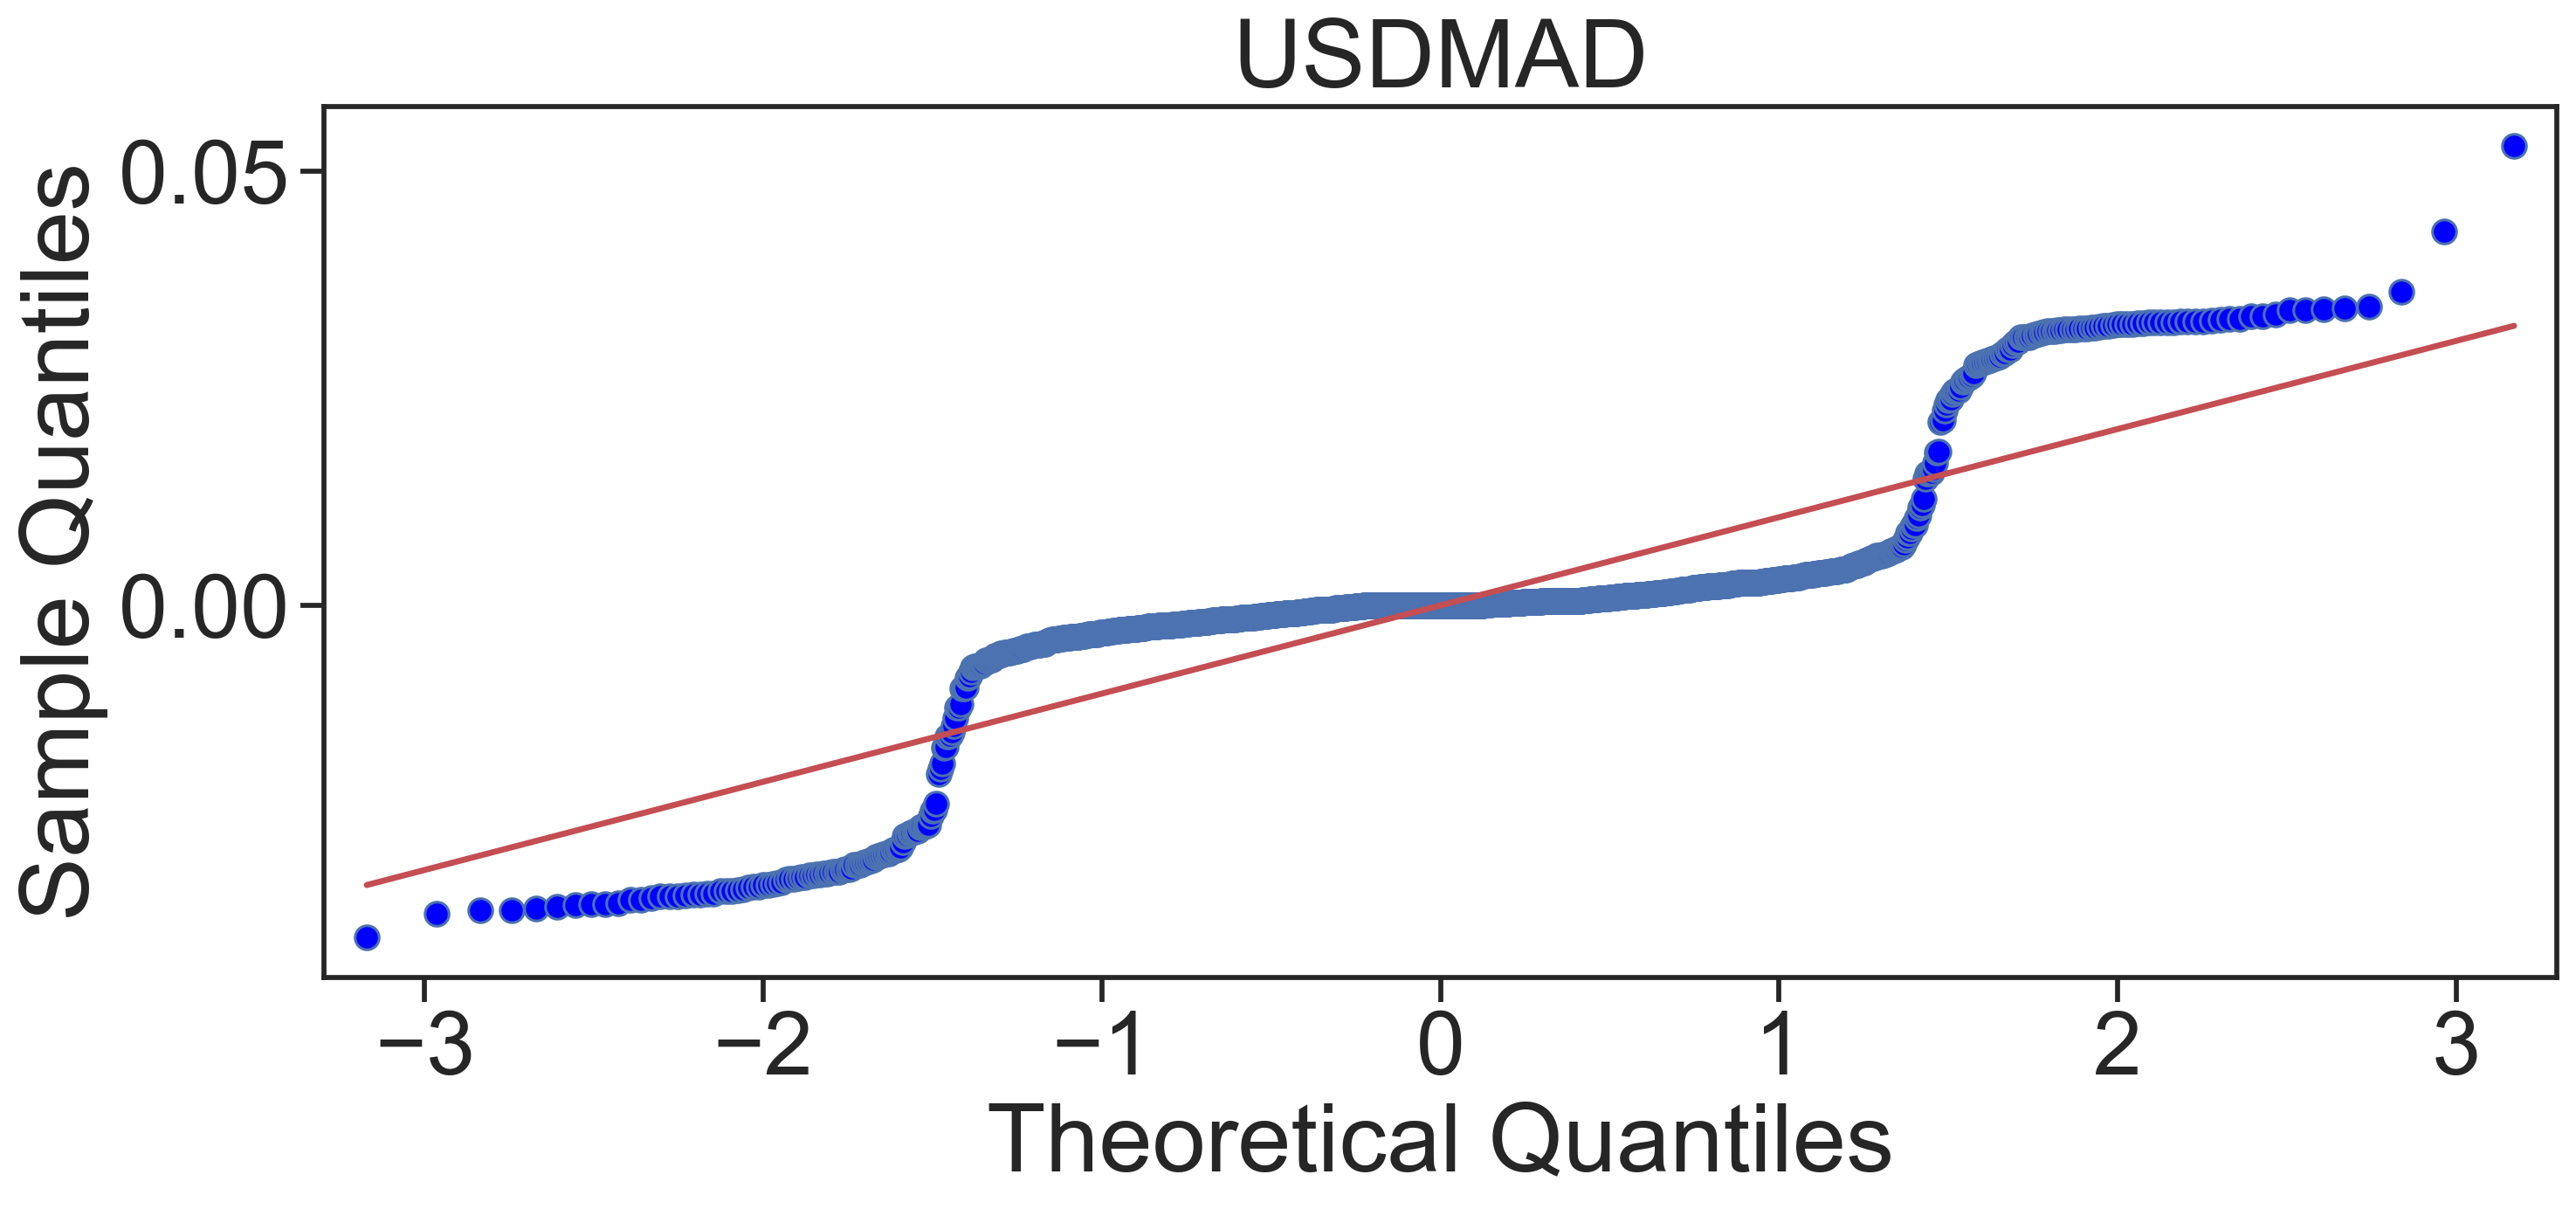

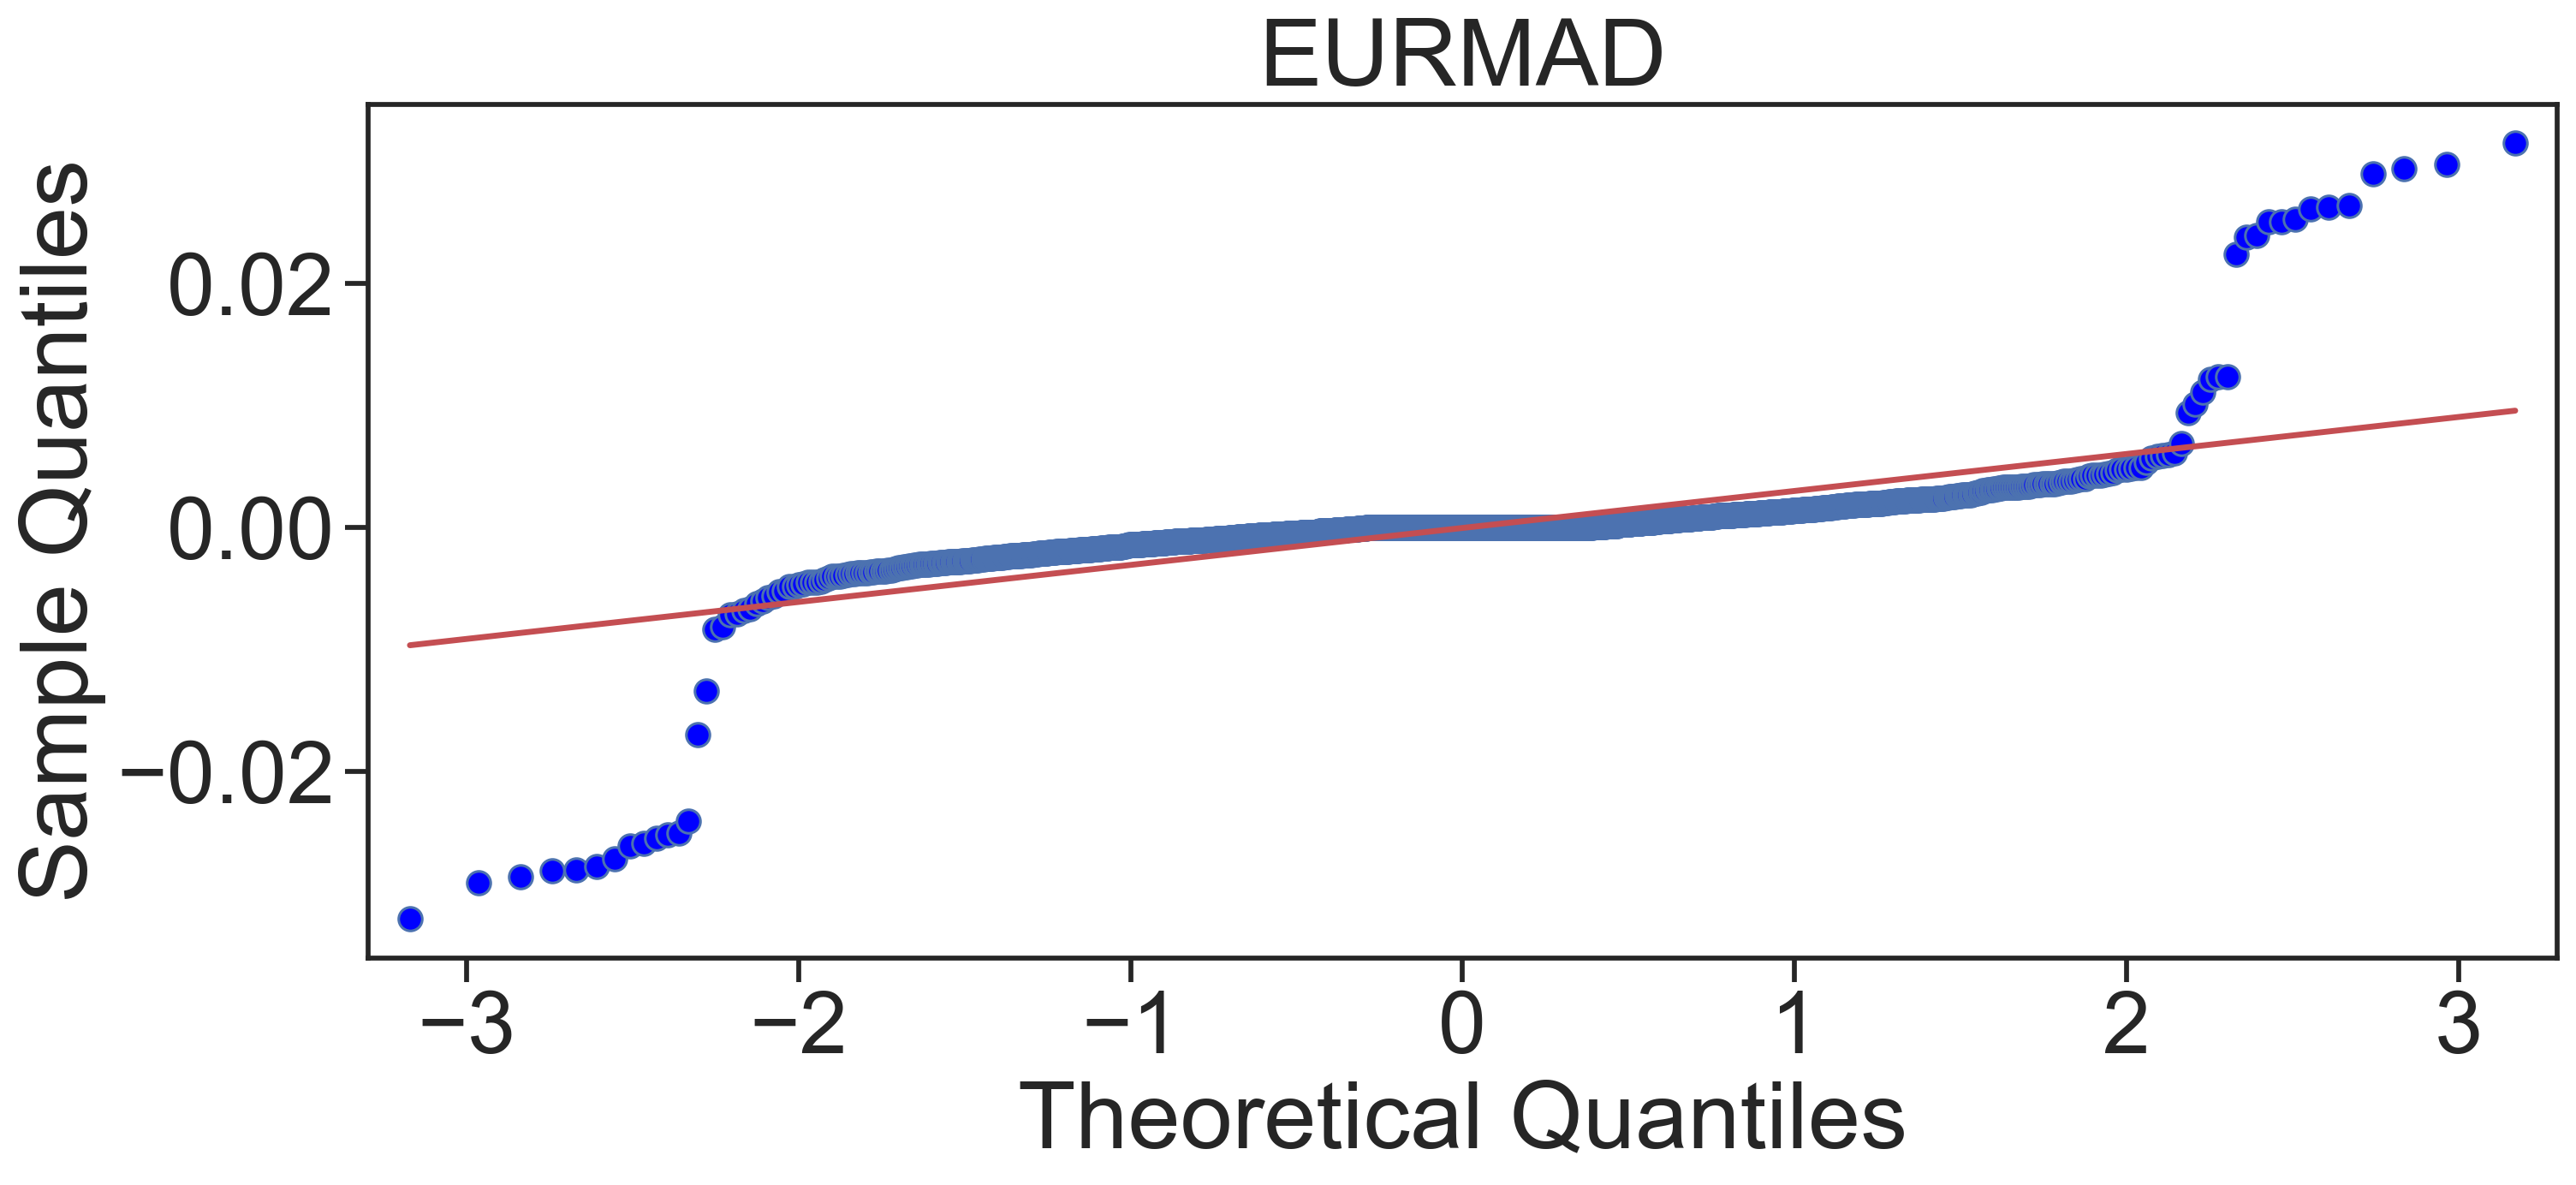

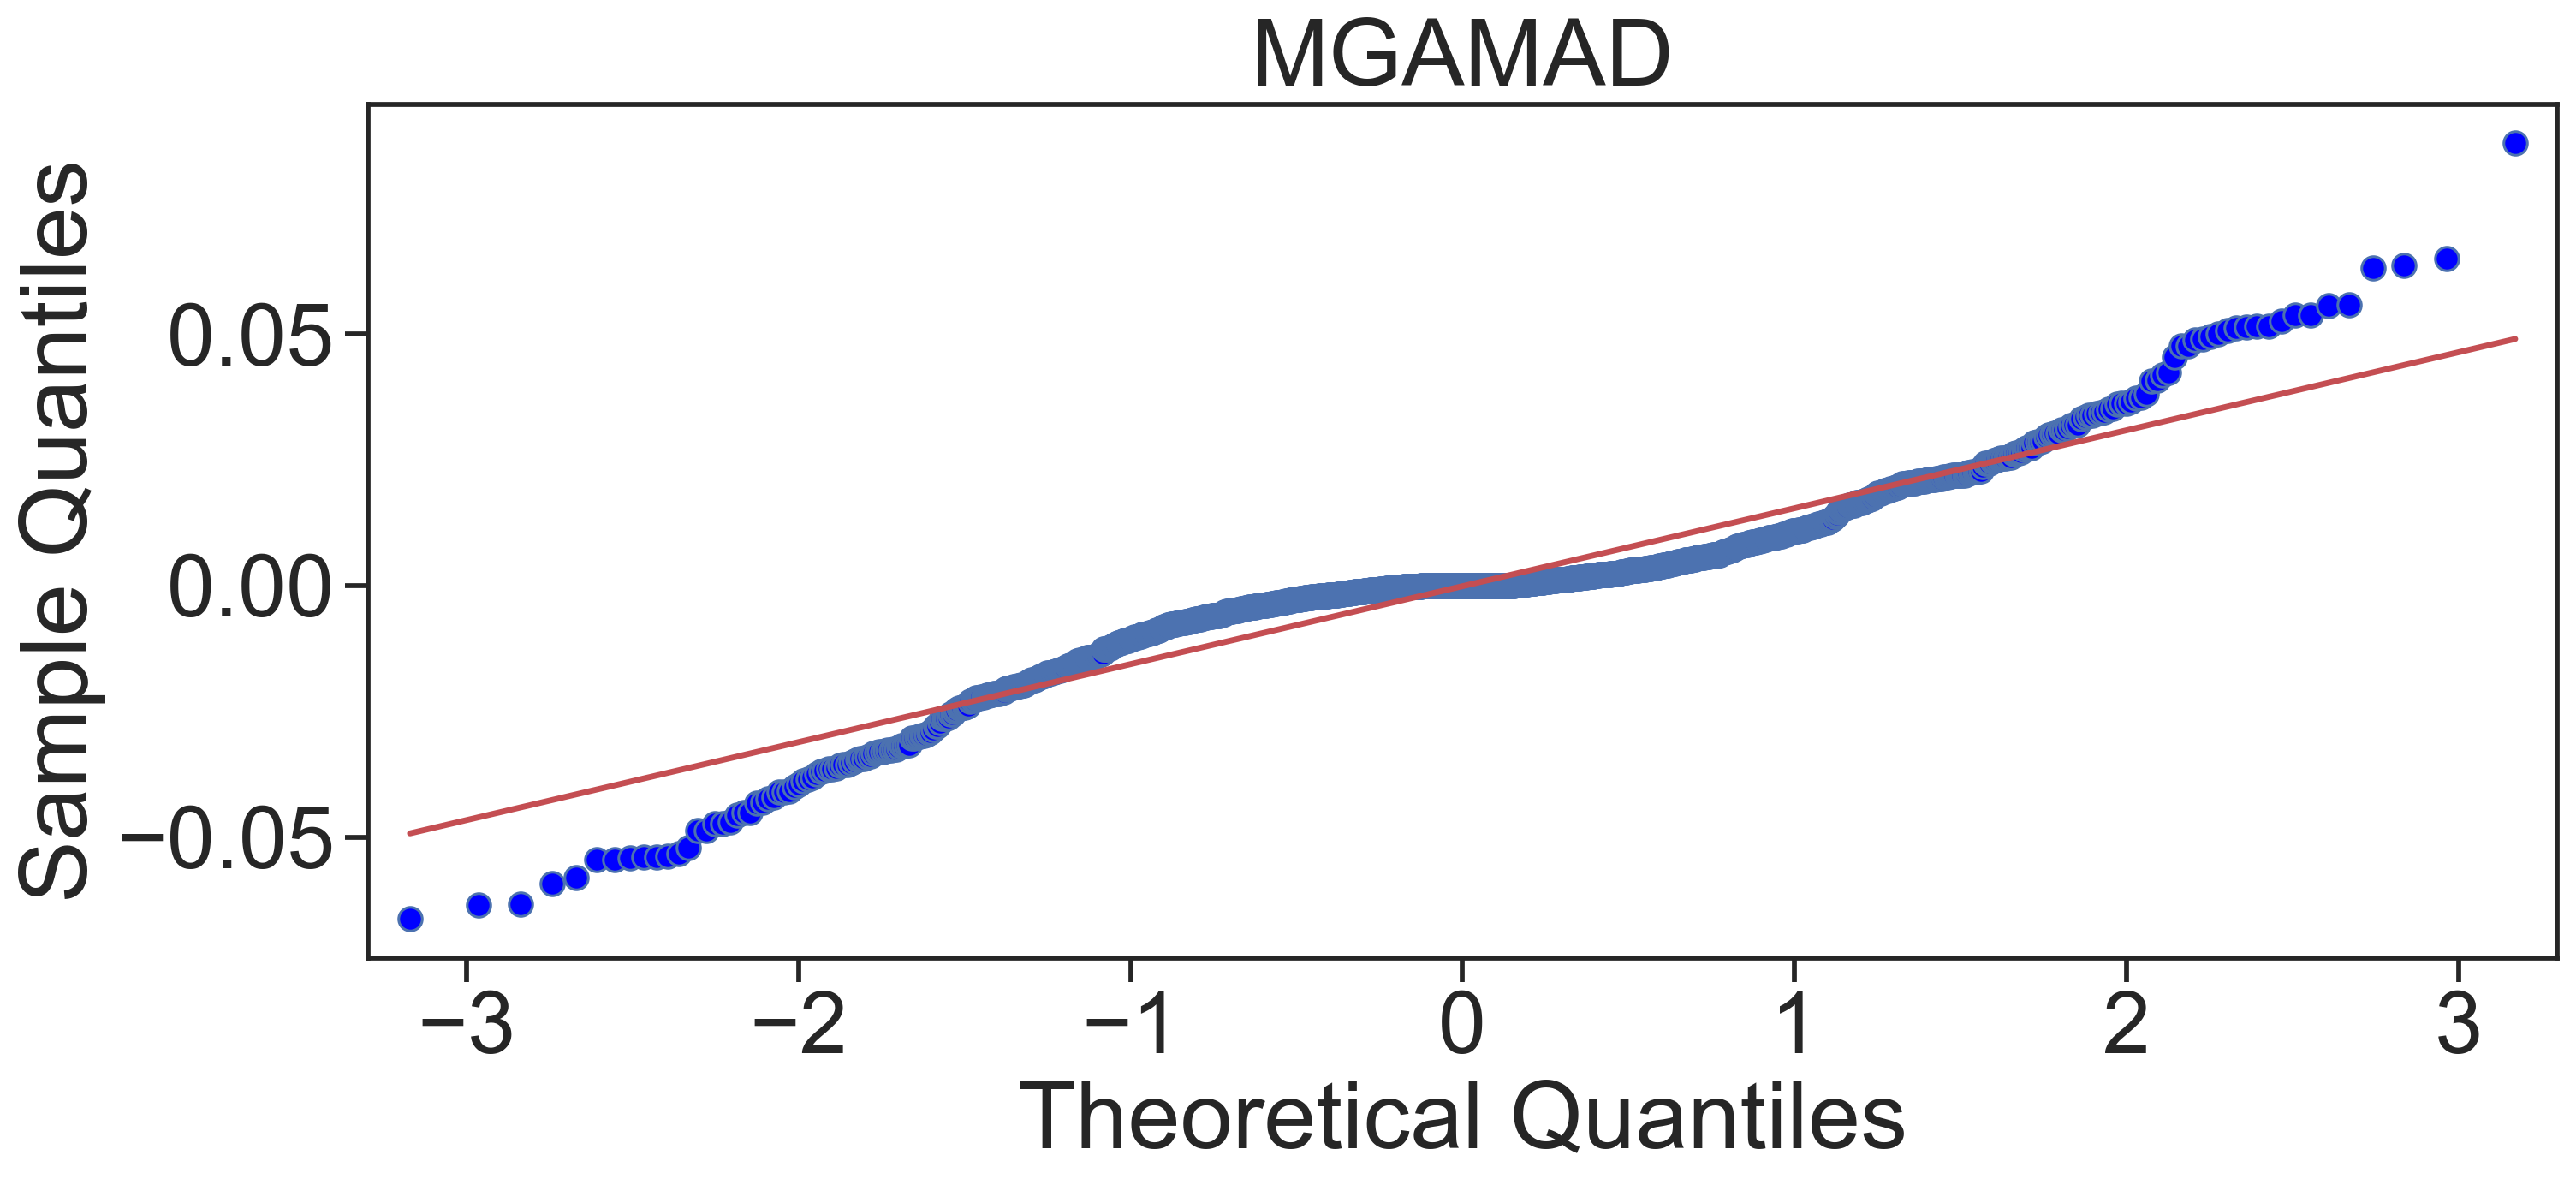

In [144]:
for ticker in tickers:
    series= log_returns[ticker].loc[((quantile95[ticker])>log_returns[ticker])|(log_returns[ticker]>(-quantile95[ticker]))]
    sm.qqplot(series, line = "r")
    plt.title(ticker)
    plt.show

Pour quelques devises, les taux de changes sans extremums converge beaucoup mieux maintenant vers la loi normmale

Dans ces cas, on pourra penser a modeliser séparément les données normales et extrèmes.

Cependant, pour l'euro et le dolar americain, l'assymetrie est beaucoup plus prononcé, on devera alors penser à un autre modèle pour les modélier, comme la distribution de weibul par exemple.
![fat_tail]("weibul.png")

*******************************************************************************************
---------------------------------------------------------
-------------------------------------------------------
--------------------------------------------------

In [145]:
import seaborn as sns
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
import warnings

<AxesSubplot:xlabel='Date'>

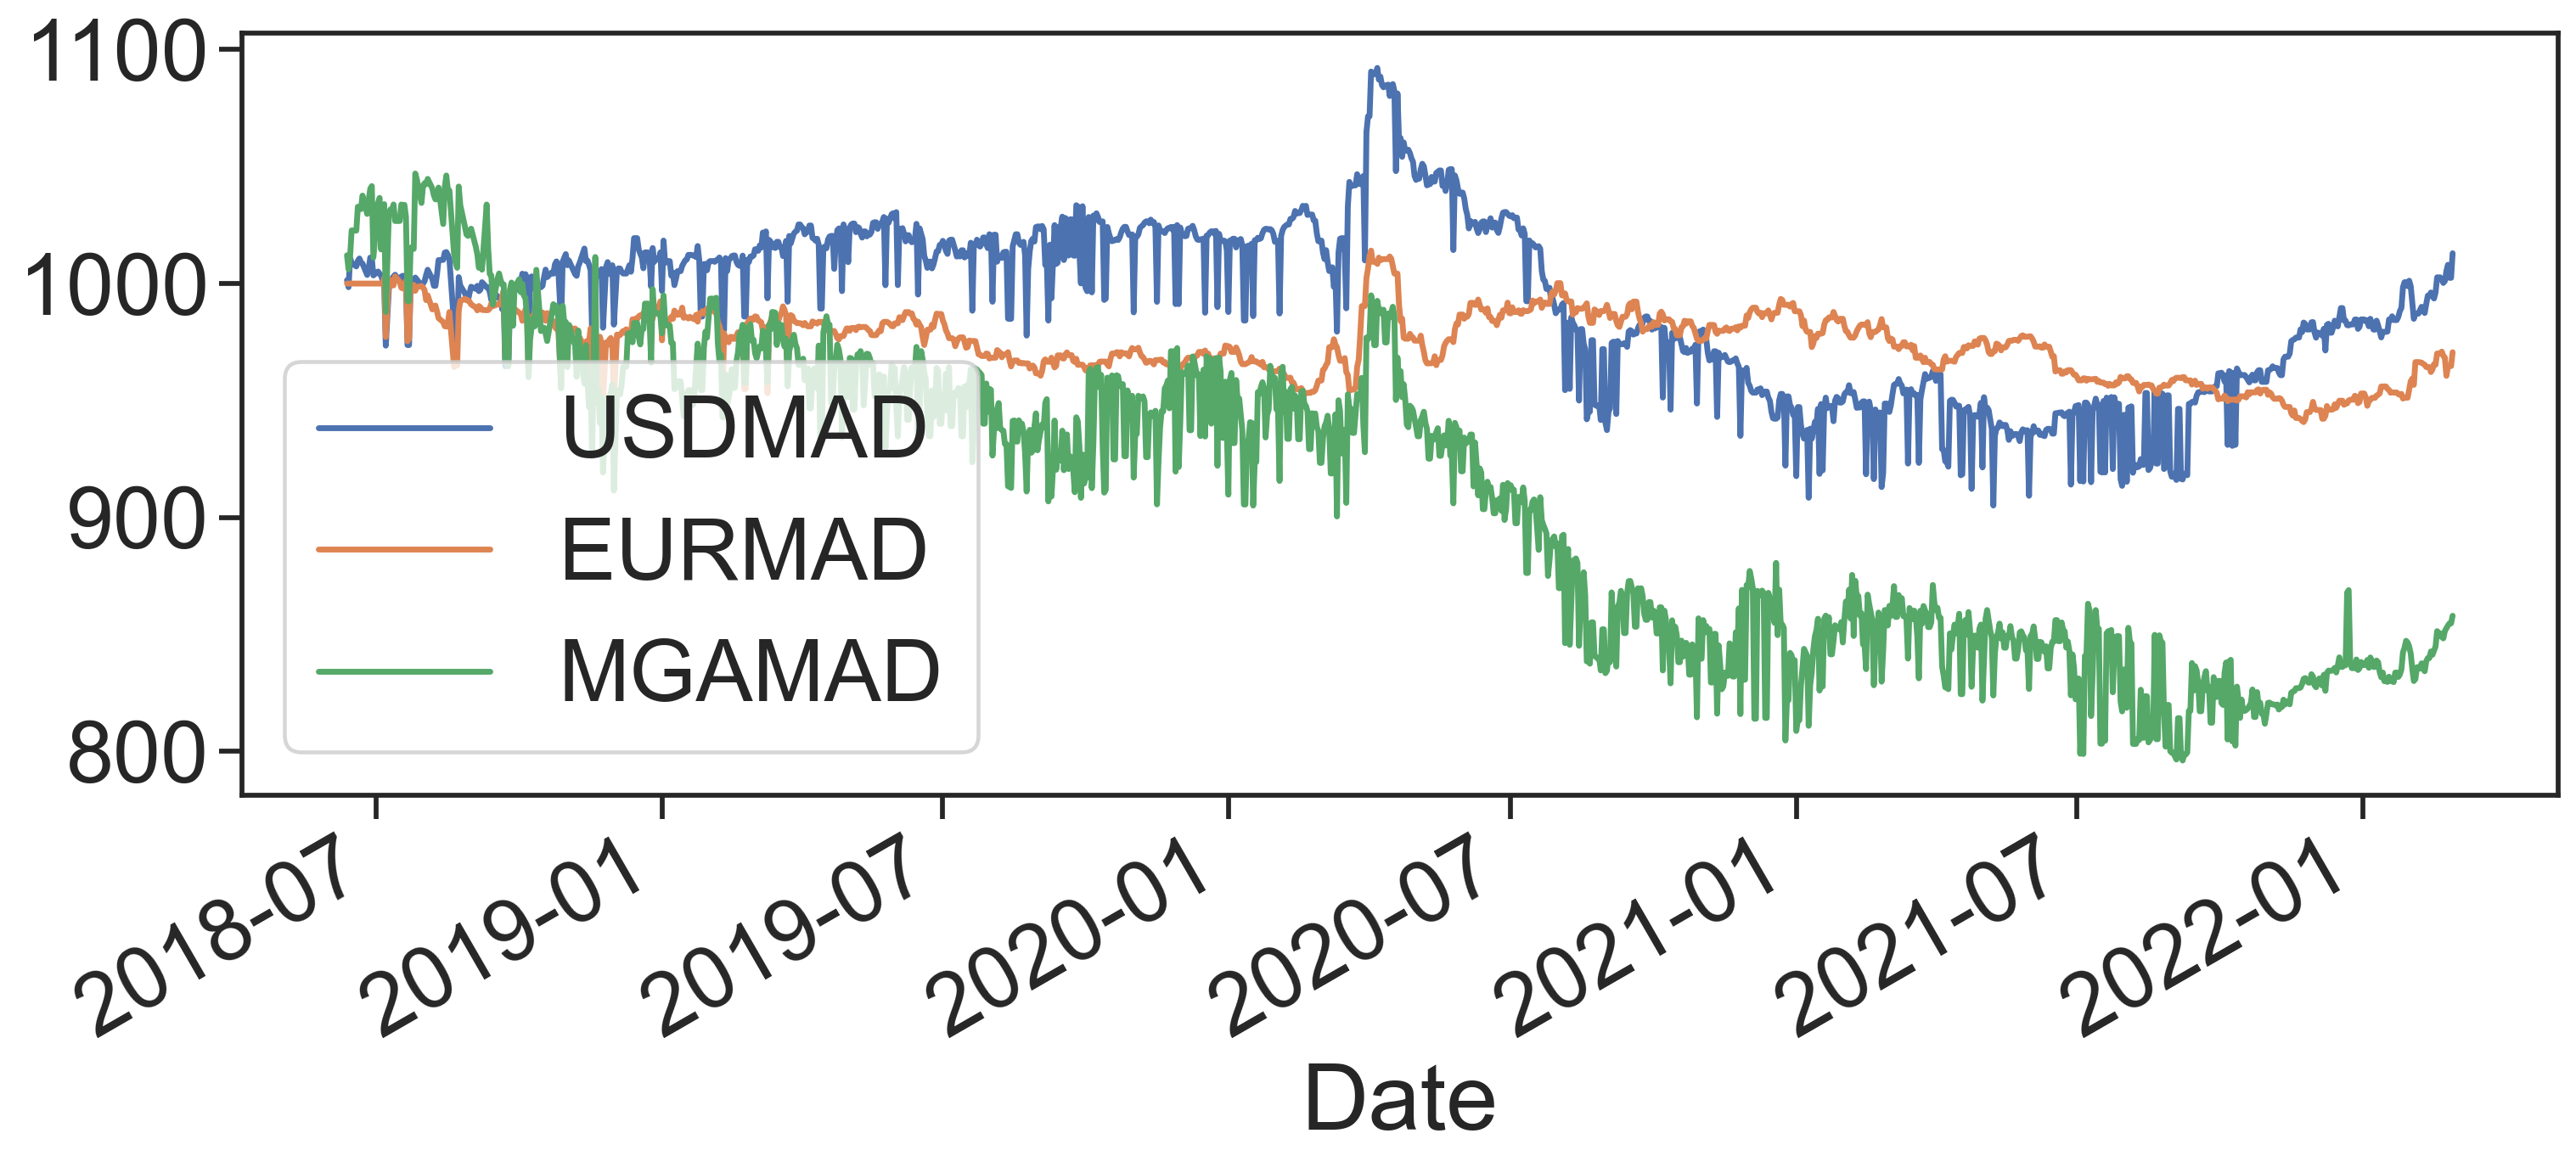

In [146]:
CERL.plot(figsize=(16,6))

# Smoothing the curves

Cette methode de determinantion de tendance nous permet d'eliminer le bruit de notre serie afin voir plus clairement ses variations à moyen et à long terme.
Le filtre de Hodrick-Prescott (HP) est devenu une référence pour se débarrasser des mouvements de tendance dans les données. Cette méthode est largement utilisée pour les méthodes économétriques dans la recherche en macroéconomie appliquée. La technique est non paramétrique et est utilisée pour dissoudre une série temporelle dans une spécification.

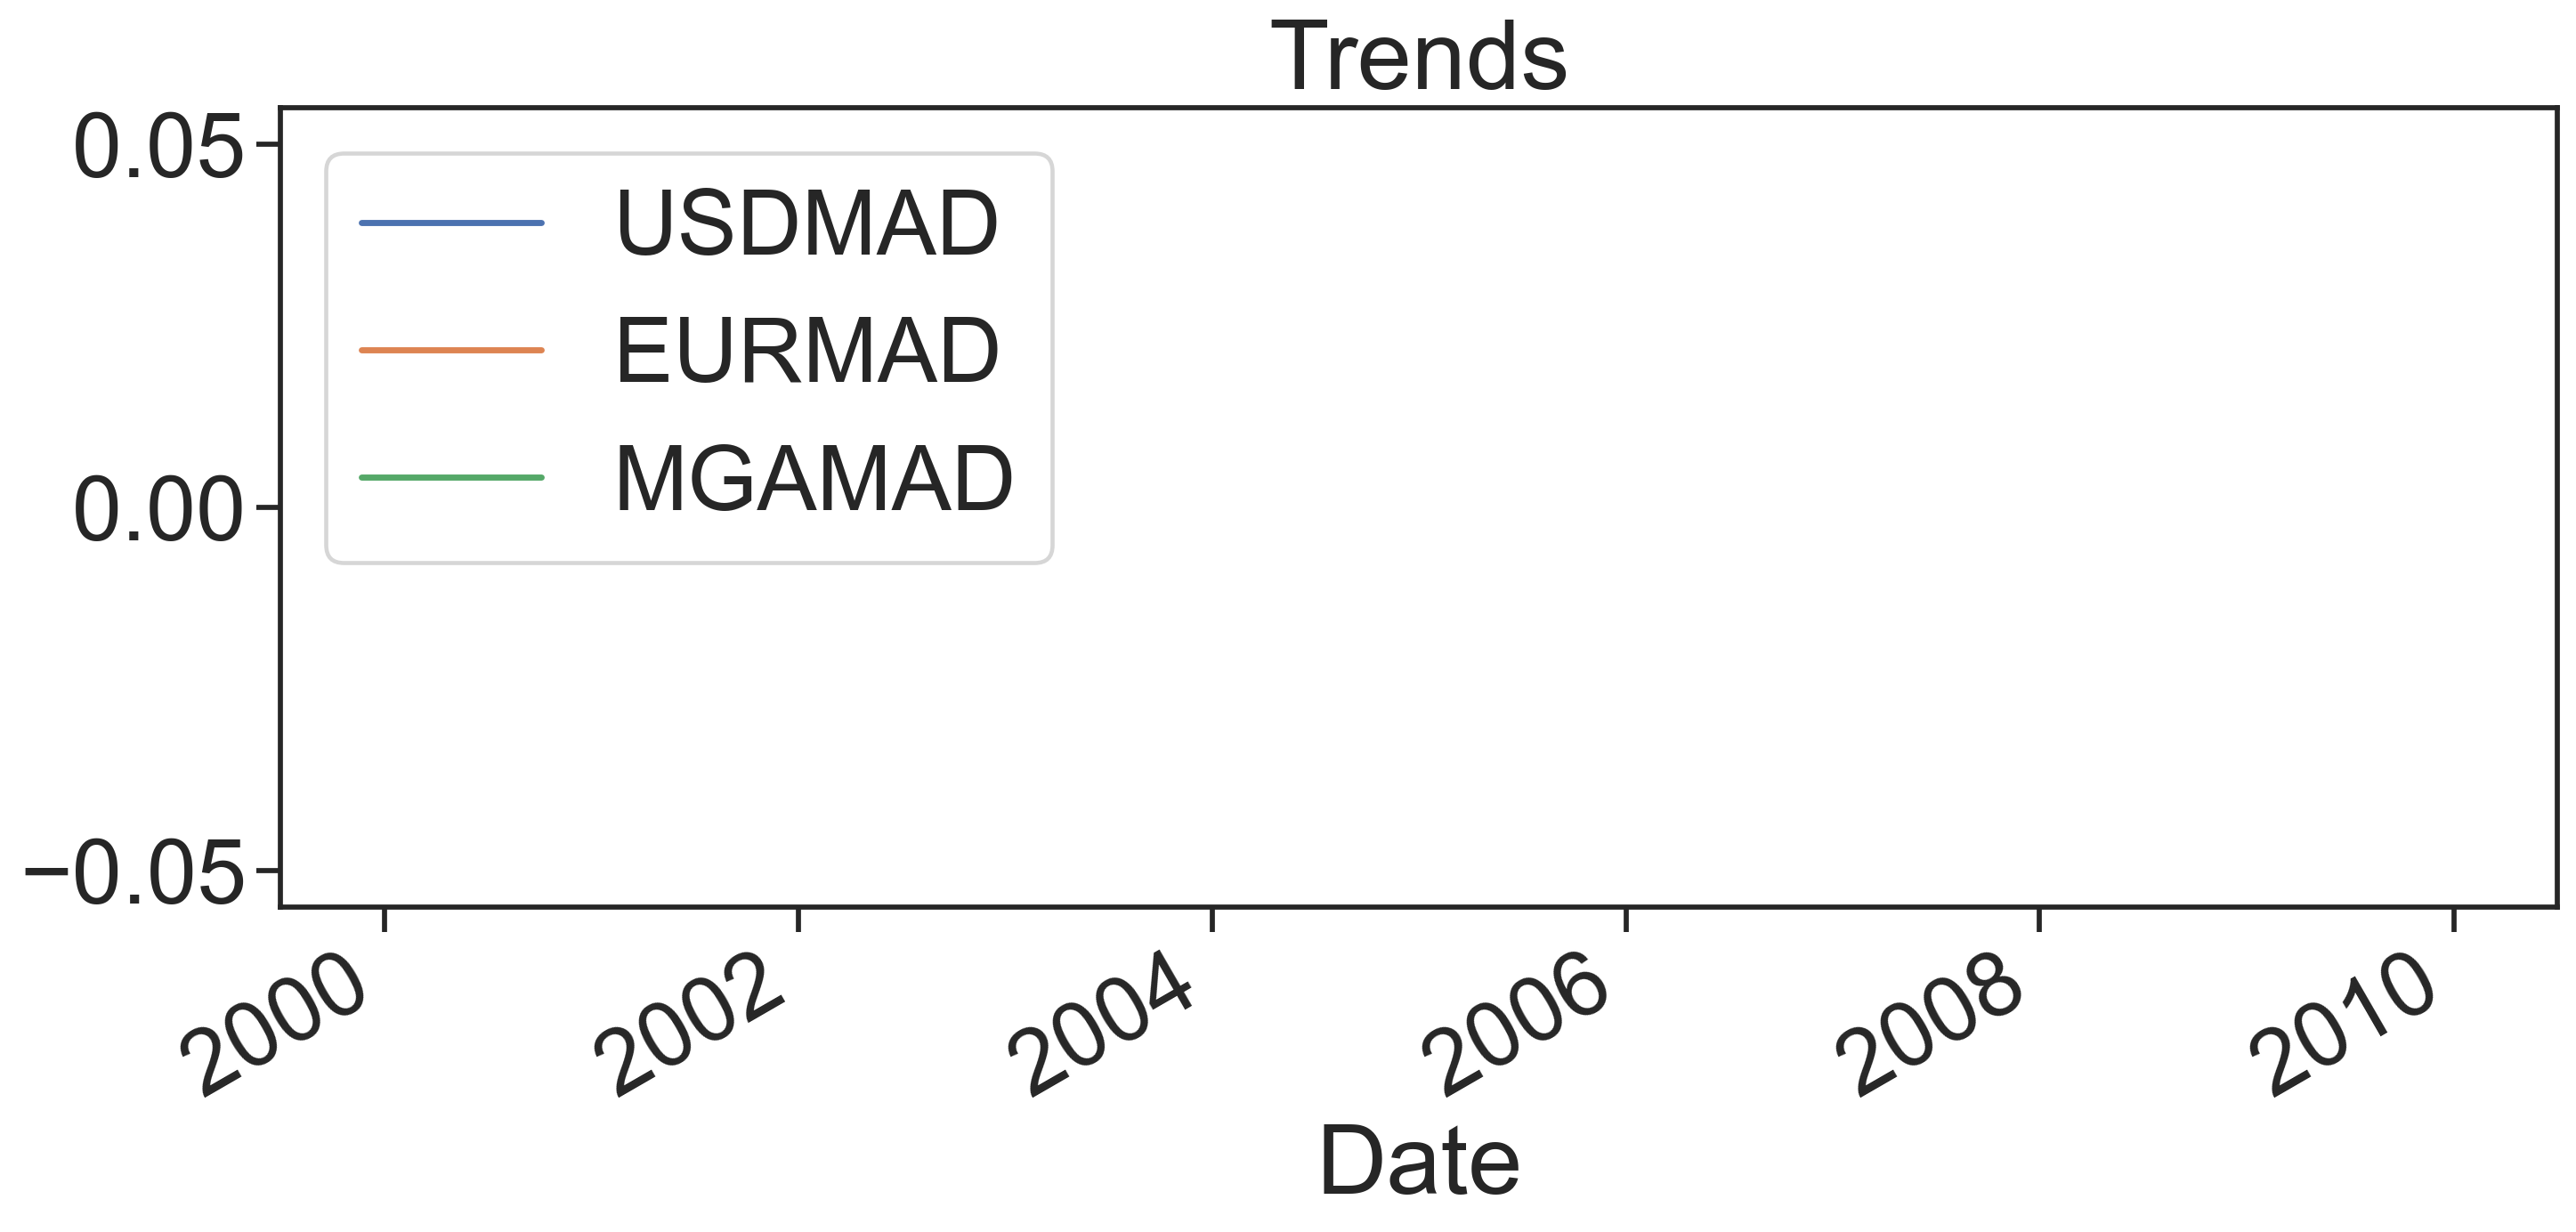

In [182]:
for ticker in tickers:
    _, trend = hpfilter(CERL[ticker], lamb=200000)
    trend.plot(label=ticker)
    plt.title("Trends")
plt.legend(loc ='upper left')
plt.show()

# Detrending the signal

In [148]:
from scipy import signal

In [150]:
detrended = pd.DataFrame(index=CERL.index, columns=CERL.columns)
for ticker in tickers:
    detrended[ticker] = pd.Series(signal.detrend(CERL[ticker]), index=detrended.index)

detrended.plot(figsize=(16,7))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.title("Detrended curve using scipy signal", fontsize=16)
plt.show()

ValueError: array must not contain infs or NaNs

In [ ]:
detrended = pd.DataFrame(index=CERL.index, columns=CERL.columns)
for ticker in tickers:
    _, trend = hpfilter(CERL[ticker], lamb=2e12)
    detrended[ticker] = CERL[ticker] - trend

detrended.plot(figsize=(16,7))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.title("Detrended curve using Hpfilter", fontsize=16)
plt.show()

# Box plot

On peut aussi utiliser un boxplot pour reperer la saisonalité monsuelle des données, un box plot représente respectivement 25%, 50% et 75% de l'échantillon, les point aux extrémités représentent les données anormales. 

In [ ]:
detrended['day'] = [d.day for d in CERL.index]
detrended['month'] = [d.month for d in CERL.index]
detrended['year'] = [d.year for d in CERL.index]
years = detrended['year'].unique()
for ticker in tickers:
    plt.figure(figsize=(15,6))
    sns.boxplot(x='month', y=ticker, data=detrended[[ticker,"day","month","year"]]).set_title("Multi Month-wise Box Plot")
    plt.show()

# Etude d'autocorélation des taux

L'autocorrélation est utilisée pour vérifier le caractère aléatoire des données. Elle permet d'identifier types de données dont la période n'est pas connue. Par exemple, pour les données mensuelles données mensuelles, s'il y a un effet saisonnier régulier, nous espérons voir des décalages massifs de pic après tous les 12 mois.

In [ ]:
from pandas.plotting import autocorrelation_plot

In [ ]:
for ticker in tickers:    
    plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':220})
    autocorrelation_plot(CERL[ticker].tolist(), label=ticker)
    plt.legend()

# Décomposition de la série temporelle

La décomposition est une méthode utilisée pour isoler les données de séries chronologiques en différents éléments tels que les tendances, la saisonnalité, la variance cyclique et les résidus. Nous pouvons exploiter la décomposition saisonnière à partir d'un modèle de statistiques. Extraction des variations cycliques à l'aide d'un filtre HP Caractéristiques des séries temporelles pour décomposer les données en leurs éléments constitutifs, en considérant les séries comme additives ou multiplicatives.
- Tendances(T(t)) signifie une augmentation ou une diminution de la  valeur des données.
- Saisonnalité(S[t]) signifie la répétition d'un cycle à court terme  des données.
- Variations cycliques(c[t]) : fluctuation des tendances à long terme des données.
- Résidus(e[t]) signifie une variation irrégulière des données ts.

Le modèle additif fonctionne avec des tendances linéaires de données de séries temporelles telles que des changements constants dans le temps. La formule du modèle additif est la suivante :

Y[t] = T[t] + S[t] + c[t] + e[t]

Le modèle multiplicatif fonctionne avec un type de données non linéaires telles que quadrique ou exponentiel. La formule du modèle multiplicatif est la suivante :

Y[t] = T[t] * S[t] * c[t] * e[t]

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
for ticker in tickers:
    seasonal_decompose(CERL[ticker], model='mul', period=600).plot()
    plt.show()

In [71]:
for ticker in tickers:
    seasonal_decompose(CERL[ticker], model='sum', period=600).plot()
    plt.show()

ValueError: x must have 2 complete cycles requires 1200 observations. x only has 1095 observation(s)

# Conclusion 

L'analyse statistique des taux de change nous a permis de remarquer que la distribution des logrendements ne suivait pas une loi normale. Il nous faut donc retirer les valeurs extrêmes pour ensuite obtenir une loi normale pour quelques devises. Pour d'autres devises, l'assymetrie des log-rendements nous pousse a envisager d'autre modèles pour modeliser ce taux : l'introduction d'un processus de Jump diffusion dans un modèle suivant une loi gaussienne ou une loi de weibul peut être
envisagée.